# Preamble

TODO

## Setup
### Imports



In [1]:
import itertools
import unicodedata
import re
import os
from pathlib import Path
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
import matplotlib
from  matplotlib.ticker import FuncFormatter
import networkx as nx

### Helper Functions

In [2]:
def flatmap(func, *iterable):
    return itertools.chain.from_iterable(map(func, *iterable))

In [627]:
def contingency_statistics(contingency):
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency)
    association = scipy.stats.contingency.association(contingency)
    return {
        "χ²": chi2,
        "p-value": p,
        "DOF": dof,
        "V": association
    }

def chi2_deluxe(xtab):
    chi2_stat, p, dof, expected = scipy.stats.contingency.chi2_contingency(xtab)
    chi2_contributions = (xtab - expected) ** 2 / expected
    p_values = chi2_contributions.apply(lambda chi2: scipy.stats.chi2.sf(chi2, df=1))
    num_cells = xtab.size  # Total number of cells (rows * columns)
    def mark_significance(p_value):
        correction = num_cells  # Use the number of cells for Bonferroni correction
        if p_value < 0.001 / correction:
            return '***'
        elif p_value < 0.01 / correction:
            return '**'
        elif p_value < 0.05 / correction:
            return '*'
        else:
            return 'n. s.'
    significance = p_values.map(mark_significance)
    signs = np.sign(xtab - expected).map(lambda x: "+" if x > 0 else "–")
    results = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    
    for row in xtab.index:
        for col in xtab.columns:
            chi2_value = chi2_contributions.loc[row, col]
            sign = signs.loc[row, col]
            p_value = p_values.loc[row, col]
            sig = significance.loc[row, col]
            results.loc[row, col] = f"{sign}, χ² = {chi2_value:.2f} {sig}"

    return results


### Style

We configure a heatmap/colour scheme for tables, set a theme for plots and configure the numbers to conform to German customs.

In [354]:
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 1)
pd.set_option("styler.format.na_rep", "–")

plt.rcParams['svg.fonttype'] = 'none' # ref https://stackoverflow.com/a/35734729

sns.set_style("ticks")
sns.set_context("paper")
cm = plt.cm.Blues

font_dir = "/nix/var/nix/profiles/system/sw/share/X11/fonts"
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[font_dir])
matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Junicode-Regular.ttf")
matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Antinoou.ttf")

plt.rcParams["font.family"] = ["Junicode", "Antinoou"]

### Assets Export

Finally, we want to set up functions for writing tables and figures to external files, so they can be included in a document.

In [306]:
subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")


def write_csv(df, the_name):
    df.to_csv(subdirectory / (the_name + '.csv'))  

def write_table(df, the_name, caption="", heatmap=False, as_ints=False, axis=None):
    style = df.style.format(precision=0, na_rep="–") if as_ints else df.style
    style = style if not heatmap else style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

### Greek/Coptic Alphabet
We also define a table mapping Unicode Greek letters to Unicode Coptic letters.
See [here](#greek-transliteration) for more info.

In [307]:
greek_to_coptic = {
  'α': 'ⲁ',
  'β': 'ⲃ',
  'γ': 'ⲅ', 
  'δ': 'ⲇ',
  'ε': 'ⲉ',
  'ζ': 'ⲍ',
  'η': 'ⲏ',
  'θ': 'ⲑ',
  'ϑ': 'ⲑ',
  'ι': 'ⲓ',
  'κ': 'ⲕ',
  'λ': 'ⲗ',
  'μ': 'ⲙ',
  'ν': 'ⲛ',
  'ξ': 'ⲝ',
  'ο': 'ⲟ',
  'π': 'ⲡ',
  'ρ': 'ⲣ',
  'σ': 'ⲥ',
  'τ': 'ⲧ',
  'υ': 'ⲩ',
  'φ': 'ⲫ',
  'χ': 'ⲭ',
  'ψ': 'ⲯ',
  'ω': 'ⲱ',
  'ς': 'ⲥ',
  'ϗ': 'ⳤ',
  '\u0314': 'ϩ',
  '\u0345': 'ⲓ',
}

consonants = set("ⲡ ⲧ ⲕ ⲃ ⲇ ⲅ ⲫ ⲑ ⲭ ϩ ⲥ ϣ ϥ ϫ ϭ ⲗ ⲣ ⳉ ϧ ⲛ ⲙ ⲍ ⲝ ⲯ".split())

vowels = set("ⲁ ⲉ ⲏ ⲓ ⲟ ⲱ ⲩ".split())

diphthongs = set("ⲁⲓ ⲉⲓ ⲏⲓ ⲟⲓ ⲩⲓ ⲱⲓ ⲁⲩ ⲉⲩ ⲟⲩ ⲏⲩ".split())

greek_to_coptic_ord = {ord(greek): ord(coptic) for greek, coptic in greek_to_coptic.items()}

# Data Processing

## Importing the Data
The CSV file we are going to use contains a large corpus of Greek words and their concrete spellings within Coptic texts, about 200K occurrences.

In [308]:
df = pd.read_csv(os.getenv("ATTESTATIONS_CSV")) \
    .set_index("id") \
    .drop(columns=["dialect"]) \
    .rename(columns={"code": "dialect"})

/tmp/ipykernel_421023/345480005.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.getenv("ATTESTATIONS_CSV")) \


Here are some random examples of these data points:

In [309]:
dialects = ["B", "F", "M", "S", "L", "A"]
df["dialect_group"] = pd.Categorical(df["dialect_group"].replace({
    "Akhmimic Dialects": "A",
    "Lycopolitan Dialects": "L",
    "Middle Egyptian Dialects": "M",
    "Sahidic Dialects": "S",
    "Bohairic Dialects": "B",
    "Fayyumic Dialects": "F"
}), dialects)

In [310]:
df.sample(5)

,quote_coptic,quote_english,orthography,encoding,coptic_lemma_id,coptic_lemma,coptic_lemma2,greek_lemma_id,greek_lemma,edition,manuscript_text,earliest,latest,?,collection,material,dialectCode,dialect_group,dialect,name
id,,,,,,,,,,,,,,,,,,,,
85389,ⲕⲁⲧⲁⲣⲟⲟⲩ ⲙⲉⲛ ϫⲉ ⲉⲩ|ϩⲩⲇⲁⲍⲉ ⲙⲙⲟϥ ϩⲛ ⲟⲩ|ⲙⲛⲧⲁⲧⲛⲁ |...,Now.according to them.it is without mercy that...,ϩⲉⲃⲣⲏⲥⲓⲥ,nn.gen0.pl.dtd,2519,ϩⲉⲃⲣⲏⲥⲓⲥ,ϩⲉⲃⲣⲏⲥⲓⲥ,3372,ὕβρις,Chapman 1991,Pierpont Morgan M.595 - Homily on the Passion ...,825.0,874.0,"4 April, 855 AD",Pierpont Morgan M.595,Parchment,S,S,S,Sahidic
19553,ⲡⲉⲛⲥⲁϩ ⲁⲩⲱ ⲡⲉⲛϫⲟⲉⲓⲥ ⲓ︦[ⲏⲥⲟⲩ]ⲥ︦ ⲡⲉ^ⲭ︦[ⲣⲓⲥⲧⲟ]ⲥ︦^...,Our teacher and our Lord Jesus ^Christ^.our Sa...,ⲭ︦ⲥ︦,nn.m.sg.dtd.an,3031,ⲭⲣⲓⲥⲧⲟⲥ,ⲭⲣⲓⲥⲧⲟⲥ,2656,χριστός,Kuhn 1956,MONB.BA - Fr. 26 - On Transgressing the Laws o...,NaN,NaN,NaN,NaN,NaN,S,S,S,Sahidic
60360,ⲡⲉⲓⲉⲃⲧⲉ ⲡⲁⲛϩ ⲛⲥⲧⲉⲫⲁⲛⲟⲥ | ⲡϣⲏⲣⲉ ⲛϩⲁⲣⲱⲛ ⲡⲙⲁ ⲉⲧⲉⲣ...,[To] the east: The court of Stephen.the son of...,ⲁⲩⲑⲉⲛ|ⲧⲉⲥ,nn.gen0.num0.dt0.inan.cnst3,449,ⲁⲩⲑⲉⲛⲧⲏⲥ,ⲁⲩⲑⲉⲛⲧⲏⲥ,335,αὐθέντης,Crum 1912,Berlin - Ägyptisches Museum P. 10606 - P.KRU 2...,NaN,NaN,NaN,Berlin - Ägyptisches Museum P. 10606,Papyrus,S,S,S,Sahidic
111652,ⲛ̄ⲧⲉⲣⲟⲩⲥⲱⲟⲩϩ ϩⲓ | ⲟⲩⲥⲟⲡ· ⲉⲩⲁⲡⲟⲣⲓ ⲉⲧⲃⲉ ⲧϩⲩⲡⲟⲥⲧⲁ...,When they got together.perplexed about the tru...,ⲡⲣⲟⲛⲟⲓⲁ,nn.f.sg.dtd,2090,ⲡⲣⲟⲛⲟⲓⲁ,ⲡⲣⲟⲛⲟⲓⲁ,1844,πρόνοια,Barry 1993,Nag Hammadi Codex III - Wisdom of Jesus Christ,NaN,NaN,NaN,NaN,NaN,S,S,S,Sahidic
96506,ⲁⲩ|ⲕⲁⲧⲁⲛⲧⲁ ⲉ|ⲡ^ⲙⲁⲣⲧⲩⲣⲓ|ⲟⲛ^ ⲙ̄ⲡϩⲁⲅⲓ|ⲟⲥ ⲕⲟⲗⲟⲩ|ⲑⲟⲥ⸱,They reached the ^martyr’s shrine^ of the holy...,ⲙⲁⲣⲧⲩⲣⲓ|ⲟⲛ,nn.m.sg.dtd,1557,ⲙⲁⲣⲧⲩⲣⲓⲟⲛ,ⲙⲁⲣⲧⲩⲣⲓⲟⲛ,1355,μαρτύριον,Schenke 2013,Paris - Bibliothèque Nationale Copte 129.15.22...,900.0,999.0,NaN,Paris - Bibliothèque Nationale Copte 129.15.22...,Parchment,S,S,S,Sahidic


In [311]:
df["earliest"].quantile([0.33, 0.67])

0.33    400.0
0.67    800.0
Name: earliest, dtype: float64

In [312]:
df["latest"].quantile([0.33, 0.67])

0.33    599.0
0.67    899.0
Name: latest, dtype: float64

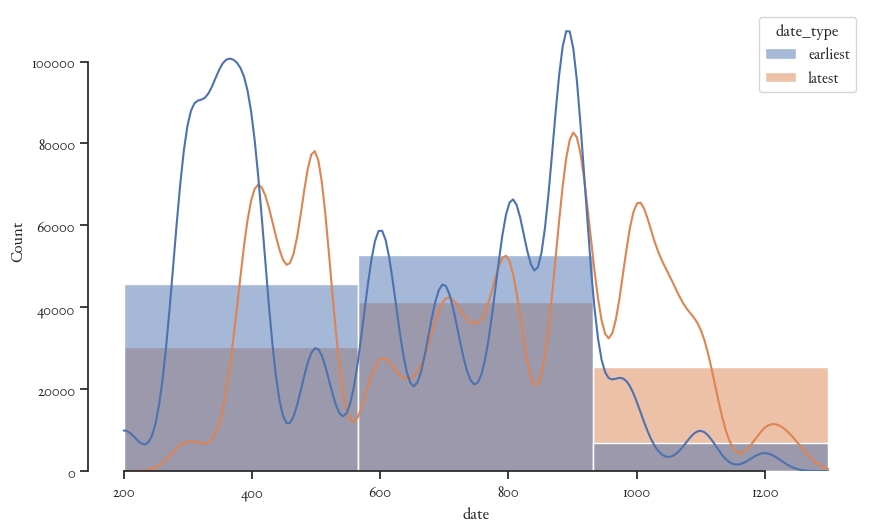

In [316]:
melted_dates = df.melt(value_vars=['earliest', 'latest'], var_name='date_type', value_name='date')
# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=melted_dates, x='date', hue='date_type', bins=3, kde=True)
sns.despine(trim=True)

## Exploring the Data

### Dates of the Texts
The data points originate from texts scattered across multiple centuries.
These are the texts, together with a plausible date range (if available):

In [13]:
df[["manuscript_text", "earliest", "latest"]].set_index("manuscript_text").drop_duplicates()

,earliest,latest
manuscript_text,,
Cambridge - Bible Society's Library pap. Q - Gospel of John,200.0,299.0
Papyrus Nag Hammadi C 002 - Genesis,200.0,399.0
London - British Library Or 4919(5) - Lamentations,NaN,NaN
Leipzig - Universität - Papyrus- und Ostrakasammlung P.Lips. Inv. 2299 - Exodus Apocryphon,200.0,499.0
Moscow - Pushkin Museum I.1.b.523 - P.MoscowCopt 90,200.0,1119.0
...,...,...
Berlin - Ägyptisches Museum P. 8324 - BKU I 18 (Healing amulet),NaN,699.0
London - British Library Or. 5525 - P.Lond.Copt. 1 524 (magical text to protect a woman and her children),NaN,899.0
London - British Library Or. 6800 - Colophon with prayer for Mena bishop of Keft,1000.0,1033.0


Because we may want to try to correlate some deviations in spelling with the time period at which they occur, we want to know how many texts lack a date (and therefore cannot be used for this analysis):

In [14]:
len(df[pd.isna(df["earliest"]) & pd.isna(df["latest"])]) / len(df)

0.4687119220970162

As we can see, almost half of the attestations of Greek words in Coptic texts lack a plausible date.
This leaves us with about 100K dateable data points, which should still be enough for robust analysis.

Since there are often two date series—an upper and a lower bound—and it is easier to work with only one series, we use the arithmetic mean of the latest and earliest dates if both are available, otherwise we use the one available date.

In [15]:
def unify_date(row):
    if not math.isnan(row["latest"]) and not math.isnan(row["earliest"]):
        return (row["latest"]+row["earliest"])/2
    elif not math.isnan(row["latest"]):
        return None
    elif not math.isnan(row["earliest"]):
        return None
    else:
        return None

df["date_approximate"] = df.apply(unify_date, axis=1)
df['century'] = (df['date_approximate'] // 100) + 1


earliest_date = df["earliest"].min()
latest_date = df["latest"].max()

def get_date_range(row):
    if not math.isnan(row["latest"]) and not math.isnan(row["earliest"]):
        return (row["earliest"], row["latest"])
    elif not math.isnan(row["latest"]):
        return (earliest_date, row["latest"])
    elif not math.isnan(row["earliest"]):
        return (row["earliest"], latest_date)
    else:
        return (earliest_date, latest_date)

df["date_range"] = df.apply(get_date_range, axis=1)

In [20]:
per_dialect = pd.DataFrame({
    "Gr. Tokens": df["dialect_group"].value_counts(),
    "Gr. Types": df.groupby("dialect_group")["greek_lemma"].unique().apply(len),
    "Texte": df.groupby("dialect_group")["manuscript_text"].unique().apply(len),
    "Datierung": df.groupby("dialect_group")["earliest"].min().astype(int).astype(str) + " – " + df.groupby("dialect_group")["latest"].max().astype(int).astype(str),
})#.sort_values(by="Gr. Tokens", ascending=False)
per_dialect.index = per_dialect.index.rename("Dialektgruppe")
write_table(per_dialect, "dialect-frequencies", caption="Häufigkeiten griechischer Lehnwörter nach Dialekt sowie Anzahl der Texte und ungefährer Belegzeitraum", heatmap=False, as_ints=False, axis=None)
per_dialect

/tmp/ipykernel_421023/4009314427.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Gr. Types": df.groupby("dialect_group")["greek_lemma"].unique().apply(len),
/tmp/ipykernel_421023/4009314427.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Texte": df.groupby("dialect_group")["manuscript_text"].unique().apply(len),
/tmp/ipykernel_421023/4009314427.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Datierung": df

,Gr. Tokens,Gr. Types,Texte,Datierung
Dialektgruppe,,,,
B,9189,1112,39,300 – 1249
F,3446,578,69,200 – 1199
M,8447,685,19,364 – 599
S,163466,4435,2963,200 – 1299
L,8462,959,130,200 – 499
A,5596,613,26,300 – 599


## Cleaning the Data
Next, it makes sense to strip some columns from the table. For our analysis of orthographical deviation, we only need the `orthography` and `greek_lemma` columns (for comparing them against each other).
For further analysis of factors such as date or dialect, we also keep the `dialect` column as well as our new `date_approximate` column.

In [21]:
df_simple = df[["orthography", "greek_lemma", "dialect_group", "date_approximate", "latest", "earliest", "date_range", "manuscript_text", "century"]]

We also want to remove any rows which for some reason either lack an `orthography` or a `greek_lemma`. We need both for our analysis.

In [22]:
df_simple = df_simple.dropna(subset={"orthography", "greek_lemma"})

In [23]:
df_simple[df_simple["greek_lemma"].str.contains(r"ρρ", regex=True)].sample(10)

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century
id,,,,,,,,,
151250,ⲑⲁⲣⲉⲓ,θαρρέω,S,NaN,NaN,NaN,"(200.0, 1299.0)",MONB.GL+GF+XJ+CZ+WY - God Says Through Those W...,NaN
165739,ⲡⲁⲣⲣⲏ|ⲥⲓⲁ,παρρησία,S,NaN,NaN,NaN,"(200.0, 1299.0)",MONB.GP - I have Been Reading the Holy Gospels,NaN
110028,ⲡⲁⲣⲣⲏⲥⲓⲁ,παρρησία,B,NaN,NaN,NaN,"(200.0, 1299.0)",INTF Acta* (bohairic) - Acts of the Apostles,NaN
129230,ⲁⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Add MS 5114 - Pistis ...,NaN
33669,ⲡⲁⲣⲣⲏⲥⲓ̄ⲁ,παρρησία,S,NaN,NaN,NaN,"(200.0, 1299.0)",Great Prayerbook of Wh. Mon. - Anaphora of Sev...,NaN
131223,ⲁⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Add MS 5114 - Pistis ...,NaN
129202,ⲁ\ⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Add MS 5114 - Pistis ...,NaN
129174,ⲁⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Add MS 5114 - Pistis ...,NaN
35164,ⲡⲁⲣⲣⲏⲥⲓⲁ̄,παρρησία,B,949.5,1099.0,800.0,"(800.0, 1099.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,10.0


We also want to remove all rows which are explicitly marked as erroneous (via `sic`) or as abbreviations, i.e. ending with `/` or similar or containing `…` or other common abbreviation characters, e.g. monograms.

In [24]:
df_simple = df_simple[~(
    df_simple["orthography"].str.contains("sic")
    | df_simple["orthography"].str.endswith(("/", "/̅", "/°")) # remove marked abbreviations
    | df_simple["orthography"].str.contains("\d|[….ⳇ⁄?ⳁ⳨Ⳁ⳧ⲋ⳦⳥⳽]", regex=True) # remove lines with numbers or marked abbreviations
)]

The `orthography` column is still littered with all kinds of combining diacritics, letter variants, capital letters or Greek script that have crept in. We therefore create an `orthography_clean` column, applying the following transformations:

In [25]:
df_simple["orthography_clean"] = (
    df_simple["orthography"]
    .str.strip() # remove extraneous whitespace
    .str.lower() # convert capital letters to lower case
    .apply(lambda x: x.translate(greek_to_coptic_ord)) # convert Greek letters that crept in
    .str.replace("ϊ", "ⲓ") # convert precombined accented greek letter
    .str.replace("[\u0305\u0304\ufe24\ufe25\ufe26\u2cf1\u2cf0\u0300]+", "", regex=True) # remove overlines
    .str.replace("[\u2CBB\u2CEF]", "ⲛ", regex=True) # normalize letter ⲛ (written as stroke)
    .str.replace("[ⳅⲹ]", "ⲍ", regex=True) # normalize letter ⲍ
    .str.replace("o", "ⲟ") # replace latin o by coptic
    .str.replace("\u001D|\u0314|\u200E|\u0486|\u02BE|\u2CFF|\u0307|\u0308|\u0301|\u0323|\u0304|\u1DCD|\u0302|\u0306" + "|" + r"col\.b|/|⟦.*?⟧|\\|\[|\]|[‖|´⸤⸥⸢⸣⁅⁆⸖'‹›`’`´:⸌⸍\⸳‧·•·ʾ*]", "", regex=True)
)

By removing all expected alphabetic characters from the orthographies, we can see how many rows still contain unexpected characters:

In [26]:
df_simple["strange_characters"] = df_simple["orthography_clean"].str.replace("[ϯϫϭⲁⲃⲅⲇⲉⲍⲏⲑⲕⲗⲙⲛⲝⲡⲣⲥⲧⲟⲱⲩⲓϩⲫϣ ⲭⳉϥⲯⲡⳤ\u0305]", "", regex=True).apply(lambda x: set(c for c in x))
df_simple[df_simple["strange_characters"].apply(lambda x: len(x) > 0)]

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters
id,,,,,,,,,,,
98756,ⲡⲣⲏⲣ[ⲱ]ⲥⲓ̈[c],πλήρωσις,S,749.5,899.0,600.0,"(600.0, 899.0)",GIOV.AM - Homily on the Passion and the Resurr...,8.0,ⲡⲣⲏⲣⲱⲥⲓc,{c}
50102,~,στοιχέω,S,749.5,799.0,700.0,"(700.0, 799.0)",Cairo - Egyptian Museum CG 8281 - O.Crum 418,8.0,~,{~}
72021,ⲁⲗⲙⲟⲩⲡⲧⲱ‵ⲛ′,(incertum),S,899.5,999.0,800.0,"(800.0, 999.0)",Paris - Louvre AF 12530 - Medical precriptions...,9.0,ⲁⲗⲙⲟⲩⲡⲧⲱ‵ⲛ′,"{‵, ′}"
72466,ⲡⲉⲣ․ⲓⲭⲣⲓⲥⲙⲁ,περίχρισμα,S,899.5,999.0,800.0,"(800.0, 999.0)",Paris - Bibliothèque Nationale Copte 132.5.1 (...,9.0,ⲡⲉⲣ․ⲓⲭⲣⲓⲥⲙⲁ,{․}
77044,[I],(incertum),S,899.5,999.0,800.0,"(800.0, 999.0)",Cairo - IFAO P.No. unknown - P.Méd.Copt. IFAO ...,9.0,i,{i}
176829,ⲁⲉⲓ|[b]ⲧⲟⲥ,ἀετός,S,NaN,NaN,NaN,"(200.0, 1299.0)",New York - The Morgan Library and Museum M.583...,NaN,ⲁⲉⲓbⲧⲟⲥ,{b}
94989,ⲙⲁⲕ⸌+⸍,μακάριος,S,NaN,NaN,NaN,"(200.0, 1299.0)",Cairo - Egyptian Museum CG 8728 - P.KRU 106 (T...,NaN,ⲙⲁⲕ+,{+}
96126,N⸌ο⸍,νόμισμα,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Or. 6721 (2) - P.KRU ...,NaN,nⲟ,{n}
96128,N⸌ο⸍,νόμισμα,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Or. 6721 (2) - P.KRU ...,NaN,nⲟ,{n}


These remaining cases are neglegible.

In [27]:
df_simple.sample(10)

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters
id,,,,,,,,,,,
107482,ⲅⲁⲣ,γάρ,S,NaN,NaN,NaN,"(200.0, 1299.0)",INTF Acta* (sahidic) - Acts of the Apostles,NaN,ⲅⲁⲣ,{}
107139,ⲃⲟⲏⲑⲓ,βοηθέω,S,NaN,NaN,NaN,"(200.0, 1299.0)",INTF Acta* (sahidic) - Acts of the Apostles,NaN,ⲃⲟⲏⲑⲓ,{}
137179,ⲧⲁⲝⲓⲥ,τάξις,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Add MS 5114 - Pistis ...,NaN,ⲧⲁⲝⲓⲥ,{}
172950,ⲡⲛ̄̄ⲁ,πνεῦμα,B,699.5,719.0,680.0,"(680.0, 719.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,7.0,ⲡⲛⲁ,{}
188100,ⲇⲉ,δέ,S,449.5,499.0,400.0,"(400.0, 499.0)",Barcelona - Palau-Ribes 183 - Gospel of John,5.0,ⲇⲉ,{}
88119,[ⲑⲏⲥⲁⲩⲣⲟⲥ],θησαυρός,S,NaN,NaN,NaN,"(200.0, 1299.0)",Oxford - Bodleian Library MS Bruce 96 - Book o...,NaN,ⲑⲏⲥⲁⲩⲣⲟⲥ,{}
157517,ⲭⲣⲓⲁ,χρεία,S,NaN,NaN,NaN,"(200.0, 1299.0)",Oxford - Bodleian Hunt 393 - Treatise on the M...,NaN,ⲭⲣⲓⲁ,{}
127326,ⲫⲁⲛⲧⲁⲥⲓ̈ⲁ̄,φαντασία,S,NaN,NaN,NaN,"(200.0, 1299.0)",New York - The Morgan Library and Museum M.578...,NaN,ⲫⲁⲛⲧⲁⲥⲓⲁ,{}
80337,ⲧⲣⲓⲙⲩⲥⲓⲟⲛ,τριμήσιον,S,NaN,NaN,NaN,"(200.0, 1299.0)",London - British Library Or. 1061 C + Or. 1062...,NaN,ⲧⲣⲓⲙⲩⲥⲓⲟⲛ,{}


## Finding Deviations

TODO

<a id="greek-transliteration"></a>
### Transliteration from Greek to Coptic

In the following, we want to compare the (normative) Greek spelling to various actual Coptic spellings.
The Greek and Coptic alphabets are handled by Unicode differently, so trying to find the differences between a word such as δίκαιος and ⲇⲓⲕⲁⲓⲟⲥ
would highlight every letter as different, because the actual codepoints of the Greek and Coptic delta, iota etc. differ.
We therefore need to "transliterate" (using quotes, because the alphabets are essentially the same) either the Coptic words into the Greek alphabet or the Greek words into the Coptic.

Because the Coptic alphabet is a superset of the Greek and we would not be able to handle specifically Egyptian characters such as ϩ, ϣ etc., we choose to convert from Greek to Coptic. 
The following three steps are necessary:

1. NFD-normalization (see [Unicode® Standard Annex #15](https://www.unicode.org/reports/tr15/) for more info): This step splits precomposed i.e. accented Greek letters into the underlying letter and one or more accent codepoints. For example: `ἅγιος` will be split into `α, ʿ, ΄, γ, ι, ο, ς`.
2. Actual transliteration: The Greek characters (and their variants, such as ϑ or ς) are mapped to their Coptic equivalents, *spiritus asper* is mapped to `ϩ`, *iota subscriptum* to normal `ⲓ`, other accents are dropped.
3. Reordering of ϩ-combinations: The last step applied to ἅγιος results in `ⲁϩⲅⲓⲟⲥ`, because according to the NFD specification, the combining breathing mark comes after the letter it applies to. Therefore any group of vowels (or *rho*) followed by ϩ must swap places with it. This also correctly converts `ⲁⲓϩⲣⲉⲱ` (← αἱρέω) to `ϩⲁⲓⲣⲉⲱ`.

TODO explain rrh

In [28]:
def transliterate(greek):
    normalized = unicodedata.normalize("NFD", greek)
    clean_spiritus_asper = lambda x: re.sub(r"^([ⲣⲁⲉⲏⲓⲟⲱⲩ]+)ϩ", r'ϩ\1', x)
    return clean_spiritus_asper(
        "".join(
            greek_to_coptic[character.lower()]
            for character in normalized
            if character.lower() in greek_to_coptic
        )
    )

See the transliteration in action here:

In [29]:
transliterate("ῥᾳδίως"), transliterate("αἱρέω"), transliterate("ἅγιος"), transliterate("παρρησία")

('ϩⲣⲁⲓⲇⲓⲱⲥ', 'ϩⲁⲓⲣⲉⲱ', 'ϩⲁⲅⲓⲟⲥ', 'ⲡⲁⲣⲣⲏⲥⲓⲁ')

It works as expected. We can now apply this transformation to the entire `greek_lemma` column:

In [30]:
df_simple["greek_lemma"] = df_simple["greek_lemma"].apply(transliterate)

### *Gestalt* Pattern Matching

The task of finding the places where two spellings of the same word vary, e.g. finding out that the difference between `ⲇⲓⲕⲁⲓⲟⲥ` and `ⲇⲓⲕⲉⲟⲥ` lies in the substitution `ⲁⲓ → ⲉ`.
Is analogous to the common computer science task of [file comparison](https://en.wikipedia.org/wiki/File_comparison).

We can therefore simply use a tool built for file comparison—Python's built-in [difflib](https://docs.python.org/3/library/difflib.html) module—for our analysis.
The algorithm used by this module is known as [*Gestalt* pattern matching](https://en.wikipedia.org/wiki/Gestalt_Pattern_Matching).

Unlike the more commonly used [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance), it works on arbitrarily long groups of characters, so the difference between the strings `ⲁⲣⲁⲯ` and `ⲁⲣⲁⲃⲟⲥ` is characterized as `replace ⲯ → ⲃⲟⲥ` instead of `replace ⲯ → ⲃ, insert ⲟ, insert ⲥ`. As can probably be seen, this better reflects the *gestalt* of the concrete difference in orthography.

But how does it work? Some examples:

1. Find the [longest common substring](https://en.wikipedia.org/wiki/Longest_common_substring) of both spellings. If there are multiple ones of equal length, the one occuring earliest will take precedence. When comparing `ⲁⲣⲁⲯ` and `ⲁⲣⲁⲃⲟⲥ`, the longest common substring is `ⲁⲣⲁ`.
2. Recurse into the left and right of that substring. Neither of the two strings has any characters left of the common substring `ⲁⲣⲁ`, so this recursion subtree is complete. To the right, we have the two strings `ⲯ` and `ⲃⲟⲥ`. We try to find the longest common substring of those two.
3. If there is no common substring, we note the difference as `replace ⲯ → ⲃⲟⲥ`. If one or the other side is empty, this is notes as either `insert XYZ` (`replace ∅ → XYZ`) or `delete XYZ` (meaning  `replace XYZ → ∅`).

Another example, this time comparing `ⲇⲓⲕⲁⲓⲟⲥ` to `ⲇⲓⲕⲉⲟⲥ`:

1. Common subsequences are `ⲇⲓⲕ` and `ⲟⲥ`. We start with `ⲇⲓⲕ`, because it is longer.
2. To the left of `ⲇⲓⲕ` both strings are empty (and thereby equal). To the right we have the strings `ⲁⲓⲟⲥ` and `ⲉⲟⲥ`.
    1. Their longest common substring is `ⲟⲥ`.
    2. To the left we have the strings `ⲁⲓ` and `ⲉ`. To the right both strings are empty (and thereby equal).
3. There is no common substring between `ⲁⲓ` and `ⲉ`. We have therefore found the one differing point. We can characterize the difference as `replace ⲁⲓ → ⲉ`.

This is all done by the `SequenceMatcher` class. Its method `get_opcodes()` returns all changes and where in the string they apply.

In [31]:
from difflib import SequenceMatcher

def get_required_edits(a, b):
    for operation, a_start, a_end, b_start, b_end in SequenceMatcher(
        a=a, b=b, autojunk=False
    ).get_opcodes():
        the_input = a[a_start:a_end]
        if len(the_input) == 0: the_input = "∅"
        the_output = b[b_start:b_end]
        if len(the_output) == 0: the_output = "∅"
        
        context_left = a[:a_start]
        if len(context_left) == 0: context_left = "#"
        context_right = a[a_end:]
        if len(context_right) == 0: context_right = "#"
        if operation == "equal": continue
        yield {"operation": operation, "input": the_input, "output": the_output, "context_left": context_left, "context_right": context_right}

For each deviation we track `input`, `output`, `context_left` (for our examples `ⲁⲣⲁ` and `ⲇⲓⲕ` respectively) and `context_right` (for our examples `#` (i.e. word boundary) and `ⲟⲥ` respectively).

In [32]:
pd.DataFrame(list(get_required_edits("ⲁⲣⲁⲯ", "ⲁⲣⲁⲃⲟⲥ")) + list(get_required_edits("ⲇⲓⲕⲁⲓⲟⲥ", "ⲇⲓⲕⲉⲟⲥ")))

,operation,input,output,context_left,context_right
0,replace,ⲯ,ⲃⲟⲥ,ⲁⲣⲁ,#
1,replace,ⲁⲓ,ⲉ,ⲇⲓⲕ,ⲟⲥ


Since the `SequenceMatcher` was not built for linguistic applications and is therefore ignorant of phonological processes,
some of its results have to be tweaked so we can more clearly recognize the changes taking place.

#### Post-Processing
##### Sub-Alignments

Sometimes, similar to the complex gemination above, two adjacent graphemes display orthographic variation.
An example: the Greek word `ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ` is occasionally spelled `ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ`. Herein, both the `ⲟ` and the `ⲕ` have been altered.
But since the Gestalt pattern matching algorithm returns the minimum amount of changes, maximising the amount of characters that can be replaced in one go, it comes up with this one replacement:

In [33]:
pd.DataFrame(get_required_edits("ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ", "ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ"))

,operation,input,output,context_left,context_right
0,replace,ⲟⲕ,ⲱⲅ,ⲡⲁⲛⲧ,ⲣⲁⲧⲱⲣ


But this can—and should—be seen as the combination of two deviations that commonly occur on their own as well.

Because we do not want to make too many assumptions with respect to the phonetic reality of the spelling (we rather want to find out more about them using this study), we want to be content with implementing a method that makes minimal assumptions and gets the job done. A less parsimonious method would for example extract phonological features (like [DORSAL, +plosive, -voiced] from `ⲕ`) and align the input and output strings based on those, mapping `ⲕ` to `ⲅ` and `ⲟ` to `ⲱ`.

Instead, we merely look at whether a grapheme reflects a consonant ($C$) or a vowel ($V$) and convert edits of the form $(\alpha_V^i)\beta_C^j\gamma_V^{k} \to ({\alpha'}_V^{i'}){\beta'}_C^{j'}{\gamma'}_V^{k'}  / s_L\_s_R$ (meaning (optionally) $i$ vowels followed by $j$ consonants followed by $k$ vowels and so on) into multiple edits $\alpha^i \to \alpha'^{i'} / s_L\_\beta^j\gamma^{k}s_R$, $\beta^j\to {\beta'}^{j'}/s_L\alpha^i\_\gamma^ks_R$, and $\gamma^k\to {\gamma'}^{k'}/s_L\alpha^i\beta^j\_s_R$ and so on. Note that this grouping approach allows $j$ consonant graphemes to be replaced by $j' \gtreqqless j$ (less or greater or equal) graphemes etc.
In reality, this is mostly applied to groups like $CV$ or $VC$.

In [34]:
remove_null = lambda x: x.replace("∅", "") if len(x) > 1 else x

group_cv = lambda string: [(b, "".join(cs)) for b, cs in itertools.groupby(string.replace("∅", ""), key=lambda x: x in vowels)]

unzip = lambda xs: zip(*xs) if xs else ([], [])

long_edits = []

def fix_CV_or_VC(edit):
    try:
        input_booleans, input_cv_groups = unzip(group_cv(edit["input"]))
        output_booleans, output_cv_groups = unzip(group_cv(edit["output"]))
        if input_booleans == output_booleans and len(input_booleans) > 1:
            edits = []
            position = 0
            context_left = ""
            context_right = "".join(input_cv_groups)
            for input_cv, output_cv in zip(input_cv_groups, output_cv_groups, strict=True):
                if len("".join(input_cv)) > 1 and len("".join(output_cv)) > 1:
                    long_edits.append(edit)
                position += len(input_cv)
                edits.append({
                    "input": "".join(input_cv),
                    "output": "".join(output_cv),
                    "context_left": remove_null(edit["context_left"] + context_left),
                    "context_right": remove_null(context_right[position:] + edit["context_right"])
                })
                context_left += "".join(input_cv)
            return edits
        else:
            return [edit]
    except ValueError:
        return [edit]

Concretely, this converts our example edit `ⲟⲕ → ⲱⲅ / ⲡⲁⲛⲧ_ⲣⲁⲧⲱⲣ`, into the following:

In [35]:
pd.DataFrame(flatmap(fix_CV_or_VC, get_required_edits("ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ", "ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ")))

,input,output,context_left,context_right
0,ⲟ,ⲱ,ⲡⲁⲛⲧ,ⲕⲣⲁⲧⲱⲣ
1,ⲕ,ⲅ,ⲡⲁⲛⲧⲟ,ⲣⲁⲧⲱⲣ


For groups of each one vowel and one consonant being changed (in whichever order — CV, VC — and how often repeated — CVC, CVCV, CVCVCV etc.) our fix works fine.
But if multiple consonants within one group change, e.g. with `ϩⲏϥⲧⲟⲙⲁⲥ` for `ϩⲉⲃⲇⲟⲙⲁⲥ`,
our heuristic manages to separate the vocalic and consonantal parts (`ⲉ → ⲏ` and `ⲃⲇ → ϥⲧ`) but does not get any further.
The rare cases where this happens would have to be looked at individually.


TODO find out  how many cases this affects

In [36]:
pd.DataFrame(flatmap(fix_CV_or_VC, get_required_edits("ϩⲉⲃⲇⲟⲙⲁⲥ", "ϩⲏϥⲧⲟⲙⲁⲥ")))

,input,output,context_left,context_right
0,ⲉ,ⲏ,ϩ,ⲃⲇⲟⲙⲁⲥ
1,ⲃⲇ,ϥⲧ,ϩⲉ,ⲟⲙⲁⲥ


##### Detecting Insertion of ϩ before vowel change 

In [37]:
def fix_insert_h(edit):
    input_booleans, _ = unzip(group_cv(edit["input"]))
    output_booleans, _ = unzip(group_cv(edit["output"]))
    if edit["context_left"] == "#" and len(output_booleans) > len(input_booleans) and edit["output"].startswith("ϩ"):
        return [{
            "input": edit["input"],
            "output": edit["output"].removeprefix("ϩ"),
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": "∅",
            "output": "ϩ",
            "context_left": edit["context_left"],
            "context_right": edit["input"] + edit["context_right"]
        }]
    else:
        return [edit]

In [38]:
pd.DataFrame(flatmap(fix_insert_h, get_required_edits("ⲉⲓⲕⲱⲛ", "ϩⲉⲓⲕⲱⲛ")))

,input,output,context_left,context_right
0,∅,,#,ⲉⲓⲕⲱⲛ
1,∅,ϩ,#,∅ⲉⲓⲕⲱⲛ


##### Detecting Degemination
Comparing the normative spelling ⲑⲁⲗⲁⲥⲥⲁ to the actual spelling ⲑⲁⲗⲁⲥⲁ gives us the following edit:

In [39]:
pd.DataFrame(get_required_edits("ⲑⲁⲗⲁⲥⲥⲁ", "ⲑⲁⲗⲁⲥⲁ"))

,operation,input,output,context_left,context_right
0,delete,ⲥ,∅,ⲑⲁⲗⲁⲥ,ⲁ


Even though this is a correct application of the algorithm and reflects the minimum amount of edits needed to transform one string into the other—ⲑⲁⲗⲁⲥ is the longest common substring after all—it does not clearly indicate what might be going on phonetically.

A deviation from ⲑⲁⲗⲁⲥⲥⲁ to ⲑⲁⲗⲁⲥⲁ is no change of ⲥ-elision (as, for example, `ⲗⲟⲅⲓⲥⲙⲟⲥ` to `ⲗⲟⲅⲓ̈ⲙⲟⲥ` would be), but rather a degemination of ⲥ, which we want to recognise as such.

Therefore we transform all rules of the form $\alpha\to \emptyset / s_L\alpha \_ s_R$ and $\alpha\to\emptyset/s_L\_\alpha s_R$ into $\alpha\alpha\to\alpha / s_L\_s_R$.

In [40]:
def fix_degemination(edit):
    input_booleans, _ = unzip(group_cv(edit["input"]))
    output_booleans, _ = unzip(group_cv(edit["output"]))
    if input_booleans == output_booleans:
        return [edit]
    if edit["output"] == "∅":
        if edit["context_left"].endswith(edit["input"]):
            geminate = edit["input"]
            return [{
                "input": geminate * 2,
                "output": geminate,
                "context_left": edit["context_left"].removesuffix(geminate),
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["input"]):
            geminate = edit["input"]
            return [{
                "input": geminate * 2,
                "output": geminate,
                "context_left": edit["context_left"],
                "context_right": edit["context_right"].removeprefix(geminate)
            }]
        else:
            return [edit]
    elif edit["context_left"].endswith(edit["input"][0]):
        geminate = edit["input"][0]
        return [{
            "input": edit["input"].removeprefix(geminate),
            "output": edit["output"],
            "context_left": edit["context_left"] + geminate,
            "context_right": edit["context_right"]
        }, {
            "input": geminate * 2,
            "output": geminate,
            "context_left": edit["context_left"].removesuffix(geminate),
            "context_right": edit["input"].removeprefix(geminate)+ edit["context_right"],
        }]
    elif edit["context_right"].startswith(edit["input"][-1]):
        geminate = edit["input"][-1]
        return [{
            "input": edit["input"].removesuffix(geminate),
            "output": edit["output"],
            "context_left": edit["context_left"],
            "context_right": geminate + edit["context_right"]
        }, {
            "input": geminate * 2,
            "output": geminate,
            "context_left": edit["input"].removesuffix(geminate),
            "context_right": edit["context_right"].removeprefix(geminate),
        }]
    else:
        return [edit]

This works as expected:

In [41]:
pd.DataFrame(
    list(flatmap(fix_degemination, get_required_edits("ⲑⲁⲗⲁⲥⲥⲁ", "ⲑⲁⲗⲁⲥⲁ"))) 
    + list(flatmap(fix_degemination, get_required_edits("ⲕⲟⲗⲗⲁⲑⲟⲛ", "ⲕⲟⲗⲟⲑⲟⲛ")))
    + list(flatmap(fix_degemination, get_required_edits("ⲁⲙⲙⲏⲧⲓ", "ⲉⲓⲙⲏⲧⲓ")))
)

,input,output,context_left,context_right
0,ⲥⲥ,ⲥ,ⲑⲁⲗⲁ,ⲁ
1,ⲁ,ⲟ,ⲕⲟⲗⲗ,ⲑⲟⲛ
2,ⲗⲗ,ⲗ,ⲕⲟ,ⲁⲑⲟⲛ
3,ⲁ,ⲉⲓ,#,ⲙⲙⲏⲧⲓ
4,ⲙⲙ,ⲙ,ⲁ,ⲏⲧⲓ


##### Detecting Gemination

On the other side, there are cases such as `ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ` for `ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ` and `ⲫⲁⲣⲓⲥⲥⲉⲟⲥ` for `ⲫⲁⲣⲓⲥⲁⲓⲟⲥ`.
Currently, they are analyzed as follows:

In [42]:
pd.DataFrame(list(get_required_edits("ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ", "ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ")) + list(get_required_edits("ⲫⲁⲣⲓⲥⲁⲓⲟⲥ", "ⲫⲁⲣⲓⲥⲥⲉⲟⲥ")))

,operation,input,output,context_left,context_right
0,insert,∅,ⲗ,ⲁⲣⲭⲁⲅⲅⲉⲗ,ⲟⲥ
1,replace,ⲁⲓ,ⲥⲉ,ⲫⲁⲣⲓⲥ,ⲟⲥ


Again, the detected edits obscure the probable phonetic reality.
The process detected for the first example—ⲗ-insertion—is exceedingly rare and only a scribal error (such as the once attested `ⲕⲁⲑⲗⲟⲗⲓⲕⲟⲛ` for `ⲕⲁⲑⲟⲗⲓⲕⲟⲛ`). Rather, it belongs to the many cases of spontaneous gemination of Greek consonants (such as `ⲑⲁⲗⲗⲁⲥⲥⲁ` for `ⲑⲁⲗⲁⲥⲥⲁ`) or diplographies (such as `ⲁⲛⲁⲥⲁⲥⲧⲁⲥⲓⲥ` for `ⲁⲛⲁⲥⲧⲁⲥⲓⲥ`).

The second example is a bit more involved. It makes sense to analyse the edit `replace ⲁⲓ → ⲥⲉ` rather as two edits: `insert ⲥ` (or even better: `replace ⲥ → ⲥⲥ`), `replace ⲁⲓ → ⲉ` (which is a common change).

To detect simple geminations as in the first example, we convert all edits of the form $\emptyset\to\alpha/s_L\alpha\_s_R$ and $\emptyset\to\alpha/s_L\_\alpha s_R$ to $\alpha\to\alpha\alpha/s_L\_s_R$ (dual to the above).
Note that this change applies to $\alpha$ of any length, so it will also catch two- or three-character diplographies.

To detect compounded geminations, we convert all edits of the form $t_1\to\alpha t_2/s_L\alpha\_s_R$ into two edits: $\alpha\to\alpha\alpha/s_L\_t_1s_R$, $t_1\to t_2/s_L\_s_R$.

With this in mind, deviation such as `ⲙⲁⲥⲥⲓⲅⲟⲱ` from `ⲙⲁⲥⲧⲓⲅⲟⲱ` ist detected as a gemination (because in the edit `ⲥ → ⲧ / ⲙⲁⲥ_ⲓⲅⲟⲱ`) the input appears on the right edge of the left context.
The described conversions now lead to two edits, one gemination: `ⲥ → ⲥⲥ / ⲙⲁⲥ_ⲓⲅⲟⲱ` and a deletion `ⲧ → ∅`.
This again obscures the probable phonetic reality: The `ⲧ` seems to be either made into a sibilant before `ⲓ` (a process which is not unusual, happening for example during the development from Proto-Indo-European into Greek (see Rix) or in the Kalamian languages (Austronesian)).
We therefore have to refine our heuristic:
Only if the input is actually shorter than the output, i.e. either an insertion like with `ⲑⲁⲗⲁⲥⲥⲁ` or a compounded gemination like with `ⲫⲁⲣⲓⲥⲥⲉⲟⲥ` above.
We check this by comparing the phonological classes of input and output (i.e. whether they are C, V, VC or CV etc.) and only convert the edit rule if those phonological classes are different.

In [43]:
def fix_gemination(edit):
    input_booleans, _ = unzip(group_cv(edit["input"]))
    output_booleans, _ = unzip(group_cv(edit["output"]))
    if input_booleans == output_booleans:
        return [edit]
    if edit["input"] == "∅":
        if edit["context_left"].endswith(edit["output"]):
            geminate = edit["output"]
            return [{
                "input": geminate,
                "output": geminate * 2,
                "context_left": edit["context_left"].removesuffix(geminate),
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["output"]):
            geminate = edit["output"]
            return [{
                "input": geminate,
                "output": geminate * 2,
                "context_left": edit["context_left"],
                "context_right": edit["context_right"].removeprefix(geminate)
            }]
        else:
            return [edit]
    elif edit["context_left"].endswith(edit["output"][0]):
        geminate = edit["output"][0]
        return [{
            "input": edit["input"],
            "output": edit["output"].removeprefix(geminate),
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": geminate,
            "output": geminate * 2,
            "context_left": edit["context_left"].removesuffix(geminate),
            "context_right": edit["input"]+edit["context_right"],
        }]
    elif edit["context_right"].startswith(edit["output"][-1]):
        geminate = edit["output"][-1]
        return [{
            "input": edit["input"],
            "output": edit["output"].removesuffix(geminate),
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": geminate,
            "output": geminate * 2,
            "context_left": edit["input"],
            "context_right": edit["context_right"].removeprefix(geminate)
        }]
    else:
        return [edit]

Applying this method to our examples, we get the expected results:

In [44]:
pd.DataFrame(
    list(flatmap(fix_gemination, get_required_edits("ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ", "ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ"))) 
    + list(flatmap(fix_gemination, get_required_edits("ⲫⲁⲣⲓⲥⲁⲓⲟⲥ", "ⲫⲁⲣⲓⲥⲥⲉⲟⲥ")))
    + list(flatmap(fix_gemination, get_required_edits("ⲙⲁⲥⲧⲓⲅⲟⲱ", "ⲙⲁⲥⲥⲓⲅⲟⲱ")))
    + list(flatmap(fix_gemination, get_required_edits("ⲉⲓⲙⲏⲧⲓ", "ⲁⲙⲙⲏⲧⲓ")))
)

,input,output,context_left,context_right,operation
0,ⲗ,ⲗⲗ,ⲁⲣⲭⲁⲅⲅⲉ,ⲟⲥ,NaN
1,ⲁⲓ,ⲉ,ⲫⲁⲣⲓⲥ,ⲟⲥ,NaN
2,ⲥ,ⲥⲥ,ⲫⲁⲣⲓ,ⲁⲓⲟⲥ,NaN
3,ⲧ,ⲥ,ⲙⲁⲥ,ⲓⲅⲟⲱ,replace
4,ⲉⲓ,ⲁ,#,ⲙⲏⲧⲓ,NaN
5,ⲙ,ⲙⲙ,ⲉⲓ,ⲏⲧⲓ,NaN


##### Protecting Vocalic Digraphs
Another problem arises with the analysis of the very common Greek-Coptic word `ⲭⲣⲉⲓⲁ`:

In [45]:
pd.DataFrame(get_required_edits("ⲭⲣⲉⲓⲁ", "ⲭⲣⲓⲁ"))

,operation,input,output,context_left,context_right
0,delete,ⲉ,∅,ⲭⲣ,ⲓⲁ


What is analysed here as a deletion of `ⲉ` in fact reflects a common tendency to write the Greek digraph `ⲉⲓ` as plain `ⲓ`,
pointing to a merger of the phonemes encoded by those letters. This is obscured by the fact that `ⲓ` does not appear in the input portion (because it is common to both strings).

A common solution would be to 'protect' the digraphs in question, i.e. convert them into one-character segments (e.g. `ⲉⲓ` into `ë`) and then run the pattern matching algorithm on these modified strings (e.g. `ⲭⲣëⲁ → ⲭⲣⲓⲁ`, resulting in a rule `ë → ⲓ`) and then convert those one-character segments in rule inputs, outputs, left and right contexts back into their respective digraphs. That's what we are going for as well.

We devise arbitrary one-character replacements for all Greek vowel digraphs and define an encoding step and a decoding step:

In [46]:
protected_digraphs = {
    "ⲁⲓ": "ä",
    "ⲉⲓ": "ë",
    "ⲏⲓ": "ḧ",
    "ⲟⲓ": "ö",
    "ⲩⲓ": "ü",
    "ⲱⲓ": "ẅ",
    "ⲁⲩ": "â",
    "ⲉⲩ": "ê",
    "ⲟⲩ": "ô",
    "ⲏⲩ": "ĥ",
    "ⲱⲩ": "ŵ",
}

def protect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(digraph, code)
    return result

def unprotect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(code, digraph)
    return result

def unprotect_edit(edit):
    return {
        "input": unprotect_digraphs(edit["input"]),
        "output": unprotect_digraphs(edit["output"]),
        "context_left": unprotect_digraphs(edit["context_left"]),
        "context_right": unprotect_digraphs(edit["context_right"])
    }

Adding these functions to the mix, we get the desired output:

In [47]:
pd.DataFrame(map(unprotect_edit, get_required_edits(protect_digraphs("ⲭⲣⲉⲓⲁ"), protect_digraphs("ⲭⲣⲓⲁ"))))

,input,output,context_left,context_right
0,ⲉⲓ,ⲓ,ⲭⲣ,ⲁ


##### Putting it All Together

We have now defined all necessary post-processing adjustments and wrap the call to the pattern matching functions so that all fixes are applied automatically on every comparison:

In [48]:
def get_required_edits_improved(x, y):
    return flatmap(fix_insert_h,
        flatmap(fix_CV_or_VC,
            flatmap(fix_degemination,
                flatmap(fix_gemination, 
                    map(unprotect_edit,
                        get_required_edits(
                            protect_digraphs(x), 
                            protect_digraphs(y)
                        )
                    )
                )
            )
        )
    )

#### Results

We apply this improved pattern match to each pair of `greek_lemma` and `orthography_clean` in our data.

In [49]:
df_diff = df_simple.apply(
    lambda row: list(get_required_edits_improved(row["greek_lemma"], row["orthography_clean"])), 
    axis=1
).explode().dropna()
df_diff = pd.DataFrame(df_diff.tolist(), index=df_diff.index)
df_diff = df_diff.merge(df_simple[["greek_lemma", "orthography", "orthography_clean", "dialect_group", "manuscript_text", "date_approximate", "earliest", "latest", "century"]], on="id")
df_diff = df_diff[df_diff["greek_lemma"].str.len() > 0]

A large part of the now detected spelling variation originates from morphological differences between the Greek dictionary form (1st person singular for verbs, nominative singular masculine for adjectives and nouns) and the form employed in coptic (a reduced form of the infinitive / the imperative, occasionally the nominative singular neuter, adverbial endings). As the morphological transformation of Greek words into Coptic is not our main focus, we can safely remove those entries:

In [50]:
print(len(df_diff))
# remove verbal endings
df_diff = df_diff[~(
    (
        df_diff["input"].str.endswith(("ⲱ", "ⲟⲙⲁⲓ", "ⲙⲓ"))
    ) & (
        df_diff["context_right"] == "#"
    )
) & ~( # remove stuff like ⲭⲟⲣⲉⲱ → ⲭⲟⲣⲉⲩⲉ
    (df_diff["context_right"] == "ⲉⲱ")
    & (df_diff["input"] == "∅")
    & (df_diff["output"] == "ⲉⲩ")
)]

# remove nominal morphology
df_diff = df_diff[~(
    (df_diff["context_right"] == "#") 
    & (
        (df_diff["input"].isin({"ⲥ", "ⲛ"}) & df_diff["output"].isin({"ⲛ", "ⲩ"}) & df_diff["context_left"].str.endswith("ⲟ"))
        | ((df_diff["input"] == "ⲟⲥ") & (df_diff["output"].isin({"ⲏ", "ⲁ", "ⲱⲛ", "ⲱ", "ⲉ", "ⲟⲩ"})))
        | ((df_diff["input"] == "ⲟⲛ") & (df_diff["output"] == "ⲁ"))
        | ((df_diff["input"] == "ⲩⲥ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲥ") & (df_diff["output"] == "ⲛ"))
        | ((df_diff["input"] == "ⲛ") & (df_diff["output"] == "ⲥ"))
        | ((df_diff["input"] == "ⲏ") & (df_diff["output"] == "ⲟⲟⲩⲉ"))
    )
) & ~(
    (df_diff["context_right"] == "ⲥ")
    & (
        ((df_diff["input"] == "ⲟ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲏ") & (df_diff["output"] == "ⲟ"))
    )
) & ~(
    (df_diff["context_left"] == "#")
    & (
        ((df_diff["input"] == "ϩ") & df_diff["output"].isin({"ⲫ", "ⲑ"}))
        | ((df_diff["input"] == "∅") & (df_diff["output"].isin({"ⲑ", "ⲧⲟⲥ"})))
    )
) & ~(
    ((df_diff["input"] == "ⲩ") & (df_diff["output"] == "ⲓ") & (df_diff["greek_lemma"] == "ⲉⲗⲁⲭⲩⲥ"))
    | ((df_diff["input"] == "ⲟⲥ") & (df_diff["output"] == "∅") & (df_diff["greek_lemma"] == "ⲓⲟⲩⲇⲁⲓⲟⲥ"))
    | ((df_diff["input"] == "ⲥ") & (df_diff["output"] == "ⲑ") & (df_diff["greek_lemma"] == "ⲡⲣⲁⲥⲥⲱ"))
    | ((df_diff["input"] == "ϩ") & (df_diff["output"] == "ⲧ") & (df_diff["greek_lemma"].isin({"ϩⲟⲩⲧⲟⲥ", "ϩⲟ", "ϩⲏ"})))
)]

# remove adverbial endings
df_diff = df_diff[~(
    (df_diff["context_right"] == "ⲥ") 
    & (df_diff["input"].isin({"ⲟ", "ⲏ"}) & (df_diff["output"] == "ⲱ"))
)]
print(len(df_diff))

85148
53152


There are also large amounts of abbreviated Greek words in Coptic texts, e.g. `ⲡⲛⲁ` for `ⲡⲛⲉⲩⲙⲁ`, `ⲭⲥ` for `ⲭⲣⲓⲥⲧⲟⲥ`.
Since deleted letters can give no clues about their phonetic reality, we can also remove all deletions for the most commonly abbreviated words (collected in the `blacklist` variable).

In [51]:
blacklist = {
    ""
    "ⲡⲛⲉⲩⲙⲁ",
    "ⲭⲣⲓⲥⲧⲟⲥ", "ⲭⲣⲏⲥⲧⲟⲥ",
    "ⲥⲧⲁⲩⲣⲟⲥ", "ⲥⲧⲁⲩⲣⲟⲱ",
    "ⲥⲱⲧⲏⲣ",
    "ⲡⲛⲉⲩⲙⲁⲧⲓⲕⲟⲥ",
    "ⲇⲉⲓⲛⲁ",
    "ⲕⲩⲣⲓⲟⲥ",
    "ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ",
    "ⲁⲙⲏⲛ" # sometimes ϥⲑ
}


# remove common abbreviations
df_diff = df_diff[~(
    (df_diff["output"] == "∅") & df_diff["greek_lemma"].isin(blacklist)
)]

In [52]:
pd.DataFrame(long_edits).sample(10)
# ϩⲉⲃⲇⲟⲙⲁⲥ ϩⲏϥⲧⲟⲙⲁⲥ,ϩⲉϥⲧⲱⲙⲁⲥ
# ⲉⲣⲅⲁⲥⲧⲏⲣⲓⲟⲛ ⲁⲗⲕⲁⲥⲧⲏⲣⲓⲟⲛ
# ⲁⲛⲧⲗⲓⲁ ⲁⲛⲇⲣⲉⲁ
# ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ ⲡⲁⲇⲱⲕⲣⲁⲧⲱⲣ
# ⲟⲅⲇⲟⲟⲥ ⲟⲕⲧⲱⲉ,ⲱⲕⲧⲱⲏ
# ⲥⲩⲅⲅⲉⲛⲉⲓⲁ ⲥⲏⲛⲕⲉⲛⲉⲓⲁ
# ⲁⲅⲅⲟⲑⲏⲕⲏ ⲁⲛⲕⲱⲑⲏⲕⲏ
# ⲁⲙⲫⲓⲃⲟⲗⲟⲥ ⲁⲛⲑⲩⲃⲟⲗⲟⲥ
# ϩⲉⲗⲕⲩⲥⲙⲁ ϩⲉⲣⲅⲓⲥⲙⲁ
# ⲡⲁⲣⲁⲅⲅⲉⲗⲓⲁ ⲡⲁⲣⲉⲛⲕⲉⲗⲓⲁ
# ⲭⲉⲧⲧⲁⲓⲟⲥ ⲭⲉⲇⲇⲉⲟⲥ
# ⲍⲱⲓⲇⲓⲟⲛ ⲥⲱϯⲟⲩⲛ
# ⲥⲓⲅⲅⲟⲩⲗⲁⲣⲓⲟⲥ ⲥⲩⲛⲕⲟⲩⲗⲁⲣⲓⲟⲥ
# ϩⲟⲓⲟⲥⲇⲏⲡⲟⲧⲉ ϩⲟⲓⲟⲛⲧⲩⲡⲟⲧⲉ

,operation,input,output,context_left,context_right
78,NaN,ⲇⲉⲱ,ⲧⲉⲓ,ⲁⲡⲟ,#
31,NaN,ⲅⲉⲱ,ⲗⲉⲓ,ϩⲟⲙⲟⲗⲟ,#
8,NaN,ⲉⲣⲅ,ⲁⲗⲕ,#,ⲁⲥⲧⲏⲣⲓⲟⲛ
65,NaN,ⲕⲉⲱ,ϭⲉⲓ,ⲇⲟ,#
73,NaN,ⲓⲅⲅⲟⲩ,ⲩⲛⲕⲟ,ⲥ,ⲗⲁⲣⲓⲟⲥ
55,NaN,ⲍⲱⲓⲇⲓⲟ,ⲥⲱϯⲟⲩ,#,ⲛ
79,NaN,ⲅⲉⲓⲟⲥ,ⲕⲓⲱⲛ,ⲕⲁⲧⲁ,#
44,NaN,ⲕⲉⲱ,ⲅⲉⲓ,ⲉⲅⲕⲁ,#
83,NaN,ⲕⲉⲱ,ⲝⲉⲓ,ⲇⲟ,#
2,NaN,ⲕⲉⲱ,ϭⲉⲓ,ⲉⲅⲕⲁ,#


In [53]:
df_diff = df_diff.rename(columns={"input": "norm", "output": "var"})

In [54]:
def get_type(rule):
    norm = rule["norm"].replace("∅", "")
    var = rule["var"].replace("∅", "")
    if all(map(lambda x: x in consonants, norm)) and all(map(lambda x: x in consonants, var)):
        return "consonants"
    elif all(map(lambda x: x in vowels, norm)) and all(map(lambda x: x in vowels, var)):
        return "vowels"
    elif norm == "":
        return "mixed (insert)"
    elif var == "":
        return "mixed (delete)"
    else:
        return "mixed"
df_diff["type"] = df_diff.apply(get_type, axis=1)


In [55]:
df_diff["deviation"] = df_diff["norm"] + "→" + df_diff["var"]

In [56]:
len(df_diff)

45779

In [57]:
df_diff["type"].value_counts()

type
vowels            23085
consonants        15416
mixed              3161
mixed (delete)     2099
mixed (insert)     2018
Name: count, dtype: int64

In [58]:
df_diff[df_diff["type"] == "consonants"].sample(10)

,norm,var,context_left,context_right,greek_lemma,orthography,orthography_clean,dialect_group,manuscript_text,date_approximate,earliest,latest,century,type,deviation
id,,,,,,,,,,,,,,,
157595,∅,,#,ⲟⲡⲱⲣⲁ,ⲟⲡⲱⲣⲁ,ϩⲟⲡⲱⲣⲁ,ϩⲟⲡⲱⲣⲁ,S,"MONB.XU+GN+DG+YR+XG+GO+YH+ZV+ZS+XL - ""Continui...",NaN,NaN,NaN,NaN,consonants,∅→
193168,∅,,#,ⲁⲙⲏⲛ,ⲁⲙⲏⲛ,ϩⲁⲙⲏⲛ,ϩⲁⲙⲏⲛ,S,Naples - Biblioteca Nazionale IB. 19.01-97 - T...,NaN,NaN,NaN,NaN,consonants,∅→
199473,∅,ⲛ,ⲭⲣⲩⲥⲟⲗⲓ,ⲑⲟⲥ,ⲭⲣⲩⲥⲟⲗⲓⲑⲟⲥ,ⲭⲣⲩⲥⲟⲗⲓⲛⲑⲟⲥ,ⲭⲣⲩⲥⲟⲗⲓⲛⲑⲟⲥ,S,New York - The Morgan Library and Museum M606 ...,862.0,800.0,924.0,9.0,consonants,∅→ⲛ
146545,ⲛⲛ,ⲛ,ⲧⲩⲣⲁ,ⲟⲥ,ⲧⲩⲣⲁⲛⲛⲟⲥ,ⲧⲩⲣⲁ|ⲛⲟⲥ,ⲧⲩⲣⲁⲛⲟⲥ,S,No. unknown (11) - Martyrdom of Elijah,862.0,800.0,924.0,9.0,consonants,ⲛⲛ→ⲛ
197243,∅,ⲛ,ⲥⲩ,ⲍⲏⲧⲏⲧⲏⲥ,ⲥⲩⲍⲏⲧⲏⲧⲏⲥ,ⲥⲩⲛⲍⲏⲧⲏⲧ,ⲥⲩⲛⲍⲏⲧⲏⲧ,S,Geneva - Fondation Bodmer 58 - Discussion with...,NaN,NaN,NaN,NaN,consonants,∅→ⲛ
187932,∅,ⲛ,ⲁⲛⲁⲃⲓⲃⲁⲍⲱ,#,ⲁⲛⲁⲃⲓⲃⲁⲍⲱ,ⲁⲛⲁⲃⲓⲃⲁⲍⲱⲛ,ⲁⲛⲁⲃⲓⲃⲁⲍⲱⲛ,L,Berlin Kephalaia Codex - The Kephalaia of the ...,404.0,375.0,433.0,5.0,consonants,∅→ⲛ
11670,ⲕ,ϭ,ⲡⲣⲟⲥⲇⲟ,ⲓⲁ,ⲡⲣⲟⲥⲇⲟⲕⲓⲁ,ⲡⲣⲟⲥⲇⲟ|ϭⲓⲁ̇,ⲡⲣⲟⲥⲇⲟϭⲓⲁ,M,New York - The Morgan Library and Museum G.67 ...,449.5,400.0,499.0,5.0,consonants,ⲕ→ϭ
101099,ⲕ,ⲅ,ⲇⲟ,ⲓⲙⲁⲍⲱ,ⲇⲟⲕⲓⲙⲁⲍⲱ,ⲧⲟⲅⲓⲙⲁⲥⲓ,ⲧⲟⲅⲓⲙⲁⲥⲓ,S,Berlin - Ägyptisches Museum P. 7999 - Physiolo...,1049.5,1000.0,1099.0,11.0,consonants,ⲕ→ⲅ
17374,∅,ϩ,ⲁ,ⲟⲣⲁⲧⲟⲥ,ⲁⲟⲣⲁⲧⲟⲥ,ⲁ[ϩⲟⲣ]ⲁ̣ⲧⲟⲛ,ⲁϩⲟⲣⲁⲧⲟⲛ,S,Nag Hammadi Codex II - Secret Book of John,NaN,350.0,NaN,NaN,consonants,∅→ϩ


Finally, for presentation, we give the "input" and "output" their correct (or at least more established) names: "norm" and "var".

In [918]:
morphological_lapsus = {"∅→ⲥ", "∅→ⲓ", "∅→", "∅→", "∅→ⲏ", "∅→ⲕ", "∅→ⲧ", "∅→ⲡ", "∅→ⲣ", "∅→ⲟⲥ", "∅→ⲟⲩ", "ⲏ→ⲁ"}

def classify(deviation):
    norm, var = deviation["norm"], deviation["var"]
    operates_in = lambda graphemes: norm in graphemes and var in graphemes
    if operates_in({"ⲧ", "ⲇ"}) or operates_in({"ⲕ", "ⲅ"}) or operates_in({"ⲃ", "ⲡ"}) or operates_in({"ⲥ", "ⲍ"}):
        return "voiced_voiceless", "nongreek"
    elif operates_in({"ⲗ", "ⲣ"}):
        return "lambdacism", "nongreek"
    elif operates_in({"ⲧ", "ⲑ"}) or operates_in({"ⲫ", "ⲡ"}) or operates_in({"ⲭ", "ⲕ"}):
        return "aspiration", "nongreek"
    elif operates_in({"∅", "ϩ"}):
        return "aspiration", "greek"
    elif operates_in({"ⲁⲓ", "ⲉ"}) or operates_in({"ⲱ", "ⲱⲓ"}) or operates_in({"ⲏⲓ", "ⲏ"}) or operates_in({"ⲏⲓ", "ⲓ"}) or operates_in({"ⲟⲓ", "ⲩ"}):
        return "monophthongization", "greek"
    elif operates_in({"ⲉⲓ", "ⲓ"}):
        return "front_vowel", "greek"
    elif operates_in({"ⲟ", "ⲱ"}):
        return "back_vowel", "greek"
    elif operates_in({"ⲟⲓ", "ⲉ"}) or operates_in({"ⲁⲓ", "ⲁ"}) or operates_in({"ⲩⲓ", "ⲩ"}):
        return "monophthongization", "nongreek"
    elif operates_in({"ⲟ", "ⲱ", "ⲟⲩ", "ⲱⲓ"}) or operates_in({"ⲁ", "ⲟ"}): # ôi ~ ô already attributed to monophthongisation
        return "back_vowel", "nongreek"
    elif operates_in({"ⲏ", "ⲉ", "ⲩ", "ⲉⲓ", "ⲓ", "ⲟⲓ", "ⲁⲓ"}) or operates_in({"ⲁ", "ⲉ"}): # ai/oi ~ e already attributed to monophthongisation
        return "front_vowel", "nongreek"
    elif operates_in({"ⲛ", "∅"}) or operates_in({"ⲙ", "∅"}) or operates_in({"ⲅ", "ⲛ"}):
        return "nasal", "nongreek"
    elif operates_in({"ⲕ", "ϭ"}) or operates_in({"ϩ", "ϣ"}) or operates_in({"ⲭ", "ϫ"}):
        return "palatalisation", "nongreek"
    elif norm == 2 * var or var == 2 * norm:
        return "gemination", "greek"
    elif operates_in({"ⲉ", "∅"}) or operates_in({"ⲓ", "∅"}) or operates_in({"ⲁ", "∅"}) or operates_in({"ⲟ", "∅"}) or operates_in({"ⲩ", "∅"}):
        return "epenthesis", "nongreek"
    elif norm == "ⲟ" and var == "ⲉ":
        return "reduction", "nongreek"
    elif operates_in({"ϥ", "ⲃ"}):
        return "spirantisation", "nongreek"
    else:
        return None, None

df_diff[["shift_class", "shift_origin"]] = df_diff.apply(classify, axis=1, result_type='expand')

In [919]:
write_csv(df_diff, "deviation-occurrences")

# Data Presentation and Analysis

## Introduction

Now that we have collected all spelling deviations across all coptic texts, we can, for example, plot them by century:

In [920]:
df_diff_well_dated = df_diff[df_diff.apply(lambda x: (x["latest"] - x["earliest"]) <= 100, axis=1)]
df_simple_well_dated = df_simple[df_simple.apply(lambda x: (x["latest"] - x["earliest"]) <= 100, axis=1)]

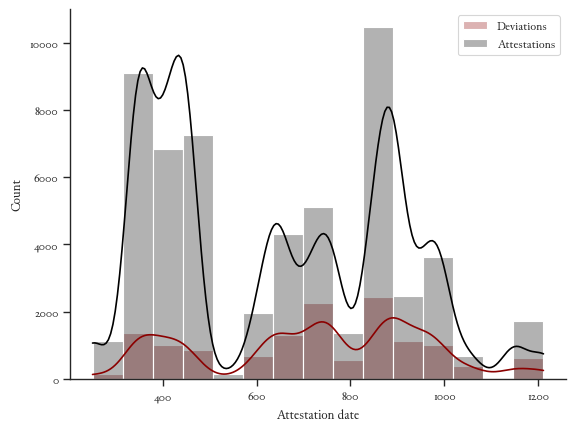

In [921]:
sns.histplot(
    data=df_diff_well_dated,
    x='date_approximate',
    bins=15,
    kde=True,
    color='darkred',
    label='Deviations',
    alpha=0.3
)

# Plot 2: df_simple_well_dated
sns.histplot(
    data=df_simple_well_dated,
    x='date_approximate',
    bins=15,
    kde=True,
    color='black',
    label='Attestations',
    alpha=0.3
)

# Styling
sns.despine(trim=False)
plt.legend()
plt.xlabel("Attestation date")
plt.ylabel("Count")
write_figure("attestations_deviations")

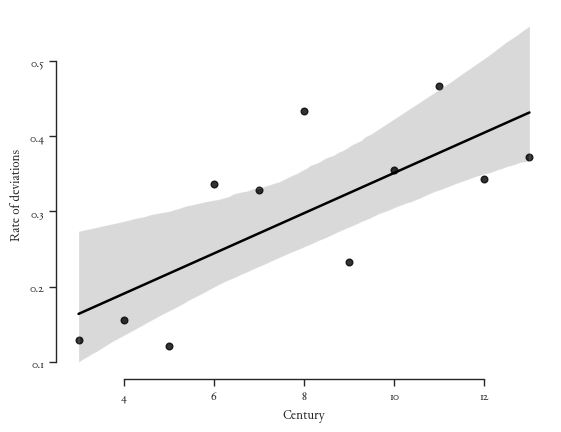

In [922]:
ratios = dates_by_century(df_diff_well_dated) / dates_by_century(df_simple_well_dated)
ratios_df = ratios.reset_index()
ratios_df.columns = ["Century", "Rate of deviations"]
sns.regplot(ratios_df, x="Century", y="Rate of deviations", color="black")
sns.despine(trim=True)
write_figure("attestations_by_deviations")

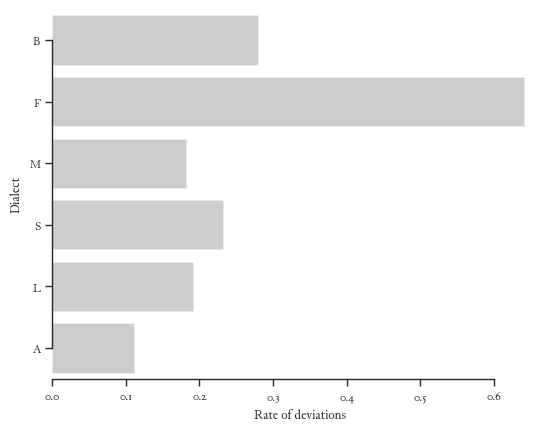

In [923]:
dialect_ratios = df_diff["dialect_group"].value_counts() / df_simple["dialect_group"].value_counts()
dialect_ratios_df = dialect_ratios.reset_index()
dialect_ratios_df.columns = ["Dialect", "Rate of deviations"]
sns.barplot(dialect_ratios_df, x="Rate of deviations", y="Dialect", color="black", alpha=0.2)
sns.despine(trim=True)
write_figure("deviations_by_dialect")

### Statistical Prerequisites: Regularity

We define the *regularity* of an orthographic deviation to be its absolute frequency (how often it did appear) divided by the frequency with which the input appears in all Greek lemmata (how often it *could* appear).

Note that the *regularity* of an insertion is undefined. We cannot count the frequency of its input, i.e. the empty string.

## (De-)Gemination

Since we earlier managed to identify geminations and degeminations, we can now look at how they are distributed in the data.

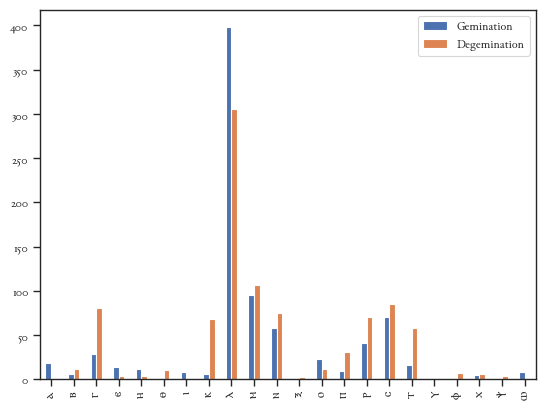

In [454]:
geminations = df_diff[(df_diff["norm"] * 2 == df_diff["var"])]
degeminations = df_diff[(df_diff["norm"] == df_diff["var"] * 2)]

interesting = vowels | consonants

geminate_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x * 2).sum() for x in interesting})

gemination_occurrences = geminations[geminations["norm"].isin(interesting)]["norm"].value_counts()
degemination_occurrences = degeminations[degeminations["var"].isin(interesting)]["var"].value_counts()

pd.DataFrame({
    "Gemination": gemination_occurrences,
    "Degemination": degemination_occurrences,
}).plot.bar()
write_figure("gemination_degemination")

/tmp/ipykernel_421023/2636604216.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x=x[1]+14, y=x[0]-5, s=key)


SignificanceResult(statistic=0.7108169694791018, pvalue=0.002024468518437725)

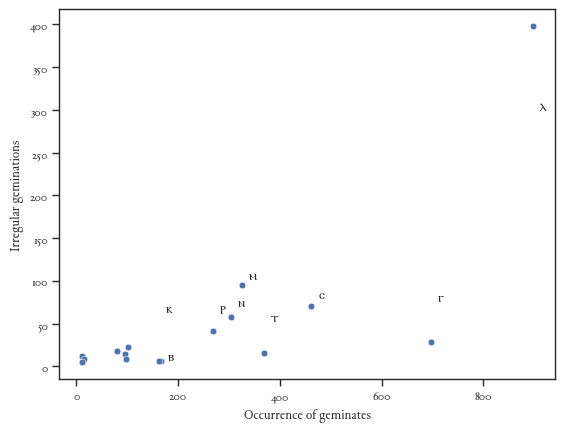

In [455]:
degemination_vs_geminates = pd.DataFrame({
    "Degemination": degemination_occurrences,
    "Geminates": geminate_occurrences,
    "Gemination": gemination_occurrences,
}).dropna()
ax = sns.scatterplot(degemination_vs_geminates, y="Gemination", x="Geminates")
plt.ylabel("Irregular geminations")
plt.xlabel("Occurrence of geminates")
for key, x in degemination_vs_geminates.iterrows():
    if any([n>=150 for n in x]):
        ax.text(x=x[1]+14, y=x[0]-5, s=key)

scipy.stats.spearmanr(degemination_vs_geminates["Geminates"], degemination_vs_geminates["Gemination"])

/tmp/ipykernel_421023/3453302514.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x=x[1]+14, y=x[0]-5, s=key)


SignificanceResult(statistic=0.8946226725838977, pvalue=2.916230122499216e-06)

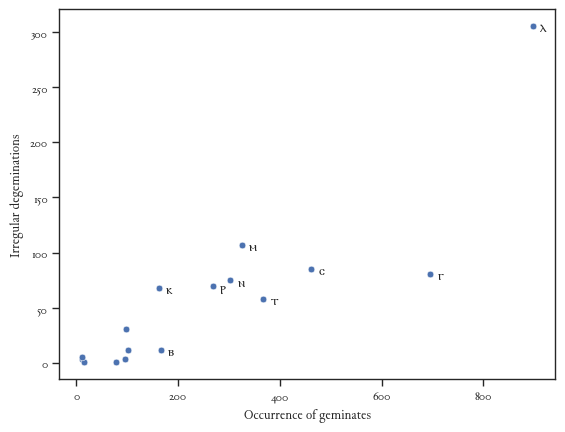

In [456]:
ax = sns.scatterplot(degemination_vs_geminates, y="Degemination", x="Geminates")
plt.ylabel("Irregular degeminations")
plt.xlabel("Occurrence of geminates")
for key, x in degemination_vs_geminates.iterrows():
    if any([n>=150 for n in x]):
        ax.text(x=x[1]+14, y=x[0]-5, s=key)

scipy.stats.spearmanr(degemination_vs_geminates["Geminates"], degemination_vs_geminates["Degemination"])

In [577]:
x_gem = geminations[geminations["norm"].isin(interesting)]
x_deg = degeminations[degeminations["var"].isin(interesting)]

x_gem_deg = pd.concat([x_gem, x_deg])

#pd.crosstab(x_gem_deg["deviation"], x_gem_deg["dialect_group"]).sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)
xtab_gem = pd.crosstab(df_diff.shift_class == "gemination", df_diff.dialect_group == "B").rename(
    columns={
        True: 'B',  # Rename True to 'Group B'
        False: 'F/M/S/L/A'    # Rename False to 'Other'
    },
    index={
        True: 'Gemination deviation',  # Rename True to 'Aspiration & Non-Greek'
        False: 'Other deviation'        # Rename False to 'Other Combinations'
    }
)
expected = scipy.stats.contingency.chi2_contingency(xtab_gem).expected_freq

print(contingency_statistics(xtab_gem))

xtab_gem

{'χ²': 0.0005143259782316011, 'p-value': 0.9819065216540869, 'DOF': 1, 'V': 0.0003493550651085073}


dialect_group,F/M/S/L/A,B
shift_class,,
Other deviation,41499,2466
Gemination deviation,1713,101


In [632]:
def categorize(row):
    if row["shift_class"] == 'aspiration' and row["shift_origin"] == "nongreek":
        return "aspiration"
    elif row['shift_class'] == "voiced_voiceless":
        return "voicing"
    else:
        return "other"

xtab_aspiration = pd.crosstab(df_diff.apply(categorize, axis=1), df_diff.dialect_group == "B").rename(
    columns={ True: 'B', False: 'non-B' },
)

print(contingency_statistics(xtab_aspiration))

xtab_aspiration #/ expected

{'χ²': 95.81070801578957, 'p-value': 1.5666396026276611e-21, 'DOF': 2, 'V': 0.04574818555160529}


dialect_group,non-B,B
row_0,,
aspiration,183,36
other,39476,2419
voicing,3553,112


In [633]:
chi2_deluxe(xtab_aspiration)

dialect_group,non-B,B
row_0,,
aspiration,"–, χ² = 2.72 n. s.","+, χ² = 45.82 ***"
other,"–, χ² = 0.12 n. s.","+, χ² = 2.07 n. s."
voicing,"+, χ² = 2.53 n. s.","–, χ² = 42.55 ***"


In [634]:
def categorize(row):
    if row['norm'] in {"ⲁ", "ⲟ"} and row['var'] in {"ⲁ", "ⲟ"}:
        return "ⲁ/ⲟ"
    elif row['norm'] == "ⲉ" and row['var'] in {"ⲁ", "ⲉ"}:
        return "ⲉ/ⲁ"
    else:
        return "other"
        
xtab_vocalism = pd.crosstab(
    df_diff.apply(categorize, axis=1),
    df_diff['dialect_group'].isin({"F", "L", "A"})
).rename(
    columns={False: "S/B", True: "F/M/L/A"}
)

# Print the contingency statistics
print(contingency_statistics(xtab_vocalism))
xtab_vocalism

{'χ²': 27.312385914032827, 'p-value': 1.1727103414571343e-06, 'DOF': 2, 'V': 0.02442568034617208}


dialect_group,S/B,F/M/L/A
row_0,,
other,40777,4407
ⲁ/ⲟ,485,14
ⲉ/ⲁ,86,10


In [635]:
chi2_deluxe(xtab_vocalism)

dialect_group,S/B,F/M/L/A
row_0,,
other,"–, χ² = 0.03 n. s.","+, χ² = 0.26 n. s."
ⲁ/ⲟ,"+, χ² = 2.61 n. s.","–, χ² = 24.36 ***"
ⲉ/ⲁ,"–, χ² = 0.01 n. s.","+, χ² = 0.05 n. s."


In [636]:
xtab_lambdacism = pd.crosstab(
    df_diff['shift_class'] == "lambdacism",
    df_diff['dialect_group'].isin({"F"})
).rename(
    columns={False: "S/B/M/L/A", True: "F"}
)
print(contingency_statistics(xtab_lambdacism))
xtab_lambdacism

{'χ²': 7.676781774180608, 'p-value': 0.005593583477722507, 'DOF': 1, 'V': 0.013784978019257647}


dialect_group,S/B/M/L/A,F
shift_class,,
False,43411,2196
True,172,0


In [637]:
chi2_deluxe(xtab_lambdacism)

dialect_group,S/B/M/L/A,F
shift_class,,
False,"–, χ² = 0.00 n. s.","+, χ² = 0.03 n. s."
True,"+, χ² = 0.42 n. s.","–, χ² = 8.25 *"


In [646]:
def classify(row):
    if row["deviation"] in {"∅→ϩ", "ϩ→∅"}:
        return row["deviation"]
    else:
        return "other"

xtab_vulgar_aspiration = pd.crosstab(
    df_diff.apply(classify, axis=1),
    df_diff['dialect_group']
).rename(
    columns={False: "S/B/M/L/A", True: "F"}
)
print(contingency_statistics(xtab_vulgar_aspiration))
xtab_vulgar_aspiration

{'χ²': 2298.1701173621714, 'p-value': 0.0, 'DOF': 10, 'V': 0.15843201215886}


dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,2159,2091,1223,34548,1472,477
ϩ→∅,300,9,11,413,18,22
∅→ϩ,108,96,295,2291,120,126


In [647]:
chi2_deluxe(xtab_vulgar_aspiration)

dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,"–, χ² = 16.06 **","+, χ² = 3.00 n. s.","–, χ² = 22.80 ***","+, χ² = 4.58 n. s.","–, χ² = 0.01 n. s.","–, χ² = 16.08 **"
ϩ→∅,"+, χ² = 1519.71 ***","–, χ² = 21.26 ***","–, χ² = 8.50 n. s.","–, χ² = 74.18 ***","–, χ² = 3.10 n. s.","+, χ² = 12.42 **"
∅→ϩ,"–, χ² = 22.75 ***","–, χ² = 16.92 ***","+, χ² = 369.63 ***","–, χ² = 13.04 **","+, χ² = 1.64 n. s.","+, χ² = 172.47 ***"


## Comparing Deviations

In the following, we want to find out which deviations are the most frequent, which are the most consistent, and at which time they are most prominent.

### Vocalic Deviations
Many of the most frequent deviations affect vocalic graphemes, with many vocalic graphemes recurring throughout multiple deviations.
We might therefore want to show a "confusion matrix" with the vocalic graphemes as rows and columns, and the regularity of their specific deviation in the matrix entries.

In [203]:
df_diff_vocalic = df_diff[df_diff["norm"].isin(vowels | diphthongs) & df_diff["var"].isin(vowels | diphthongs)]
vowel_frequency_data = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"])

# Get the unique indices and columns
unique_labels = list(set(vowel_frequency_data.index).union(set(vowel_frequency_data.columns)))

# Create a new DataFrame with the unique labels as both index and columns
vowel_frequency = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

# Update the new DataFrame with the values from the original crosstab
vowel_frequency.update(vowel_frequency_data)

# Now you can write the square crosstab to your table
write_table(vowel_frequency, "vowel_frequency", heatmap=True, caption="Abweichungen bei vokalischen Graphemen: Häufigkeit")
vowel_frequency.style.background_gradient(axis=None, cmap=cm)


,ⲏ,ⲉⲩ,ⲩⲓ,ⲏⲓ,ⲩ,ⲉⲓ,ⲉ,ⲁⲩ,ⲁⲓ,ⲟⲓ,ⲟ,ⲓ,ⲱ,ⲟⲩ,ⲱⲓ,ⲁ,ⲏⲩ
ⲏ,0,5,0,4,1080,71,900,1,7,30,18,607,10,7,0,70,12
ⲉⲩ,9,0,0,0,7,0,39,2,7,1,5,4,3,7,0,3,6
ⲩⲓ,3,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0
ⲏⲓ,68,0,0,0,6,0,2,0,0,0,0,19,0,0,0,0,0
ⲩ,527,4,0,0,0,7,314,0,9,10,27,239,6,29,0,26,1
ⲉⲓ,73,0,0,0,25,0,130,0,8,14,0,4784,1,0,0,22,0
ⲉ,379,3,0,0,318,100,0,0,141,8,18,253,4,2,0,96,0
ⲁⲩ,0,1,0,0,2,0,0,0,0,0,0,0,1,0,0,6,0
ⲁⲓ,87,0,1,0,40,37,1448,1,0,14,5,29,3,0,0,341,0
ⲟⲓ,80,0,0,0,21,18,193,0,36,0,12,77,2,1,6,0,0


In [204]:
vowel_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs})

In [205]:
# Make a copy to avoid modifying original
norm_confusion = vowel_frequency.copy()

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in vowel_occurrences:
        total = vowel_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

/tmp/ipykernel_421023/969087427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.000343335851129575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_421023/969087427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00027466868090365995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_421023/969087427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0741605438439882' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] =

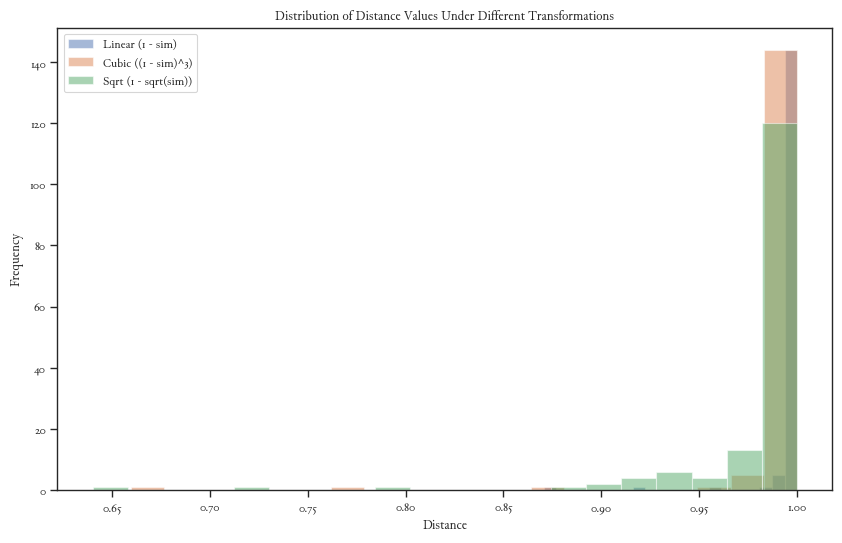

In [528]:
import matplotlib.pyplot as plt
import numpy as np

sim_matrix = sym_norm_confusion

# Flatten upper triangle of distance matrix, excluding diagonal
def get_dist_values(dist_matrix):
    mask = np.triu(np.ones(dist_matrix.shape), k=1).astype(bool)
    return dist_matrix.values[mask]

# Compare different transformations
methods = {
    "Linear (1 - sim)": 1 - sim_matrix,
    "Cubic ((1 - sim)^3)": (1 - sim_matrix) ** 3,
    #"Log (-log(sim))": -np.log(sim_matrix + 1e-6),
    "Sqrt (1 - sqrt(sim))": 1 - np.sqrt(sim_matrix)
}

plt.figure(figsize=(10, 6))
for label, mat in methods.items():
    vals = get_dist_values(mat)
    plt.hist(vals, bins=20, alpha=0.5, label=label)

plt.legend()
plt.title("Distribution of Distance Values Under Different Transformations")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [207]:
#distance_matrix = 1 - sym_norm_confusion.values
#distance_matrix = -np.log(sym_norm_confusion.values + 0.001)
#distance_matrix = (1 - sym_norm_confusion.values) ** 3
distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix


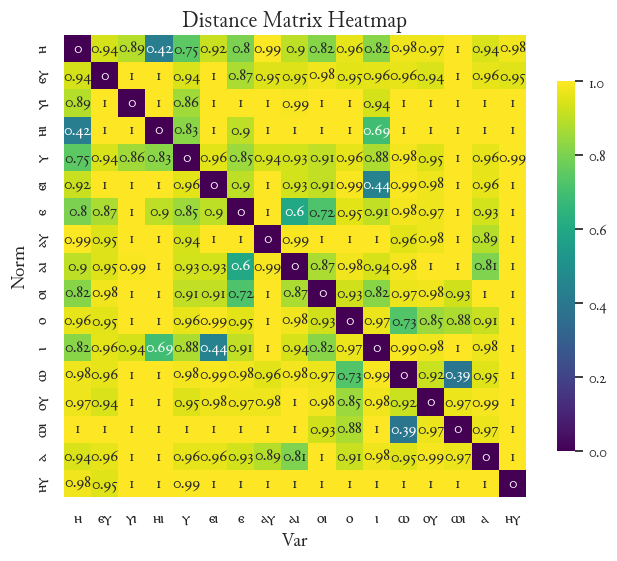

In [208]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

/tmp/ipykernel_421023/3096992990.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


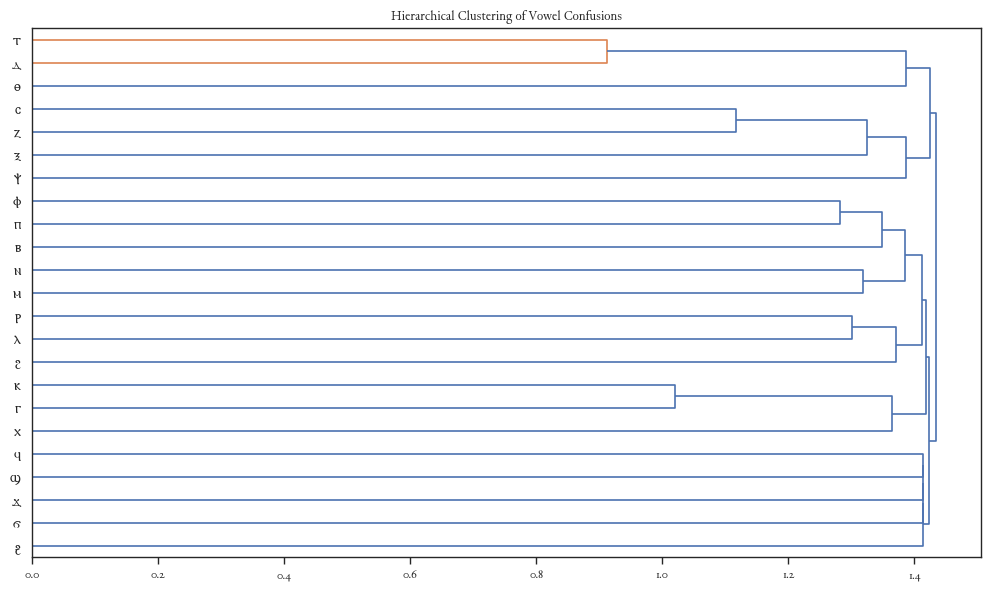

In [526]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Vowel Confusions")
plt.tight_layout()
plt.show()


In [527]:
vowel_regularity = 100 * vowel_frequency.div(vowel_occurrences, axis="rows").fillna(0)
#vowel_regularity = vowel_regularity.loc[vowel_regularity.any(axis=1), vowel_regularity.any(axis=0)]
write_table(vowel_regularity, "vowel_regularity", heatmap=True, caption="Abweichungen bei vokalischen Graphemen: Regelmäßigkeit")
vowel_regularity.style.background_gradient(axis=None, cmap=cm)

,ⲏ,ⲉⲩ,ⲩⲓ,ⲏⲓ,ⲩ,ⲉⲓ,ⲉ,ⲁⲩ,ⲁⲓ,ⲟⲓ,ⲟ,ⲓ,ⲱ,ⲟⲩ,ⲱⲓ,ⲁ,ⲏⲩ
ⲁ,"0,1","0,0","0,0","0,0","0,0","0,0","0,5","0,0","0,0","0,0","0,9","0,1","0,0","0,0","0,0","0,0","0,0"
ⲁⲓ,"1,9","0,0","0,0","0,0","0,9","0,8","31,8","0,0","0,0","0,3","0,1","0,6","0,1","0,0","0,0","7,5","0,0"
ⲁⲩ,"0,0","0,4","0,0","0,0","0,8","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,4","0,0","0,0","2,4","0,0"
ⲉ,"1,5","0,0","0,0","0,0","1,3","0,4","0,0","0,0","0,6","0,0","0,1","1,0","0,0","0,0","0,0","0,4","0,0"
ⲉⲓ,"0,9","0,0","0,0","0,0","0,3","0,0","1,6","0,0","0,1","0,2","0,0","59,5","0,0","0,0","0,0","0,3","0,0"
ⲉⲩ,"0,8","0,0","0,0","0,0","0,6","0,0","3,3","0,2","0,6","0,1","0,4","0,3","0,3","0,6","0,0","0,3","0,5"
ⲏ,"0,0","0,0","0,0","0,0","7,4","0,5","6,2","0,0","0,0","0,2","0,1","4,2","0,1","0,0","0,0","0,5","0,1"
ⲏⲓ,"67,3","0,0","0,0","0,0","5,9","0,0","2,0","0,0","0,0","0,0","0,0","18,8","0,0","0,0","0,0","0,0","0,0"
ⲏⲩ,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
ⲓ,"2,2","0,0","0,0","0,0","0,5","2,3","0,8","0,0","0,1","0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0"


In [211]:
deviation_frequency = pd.crosstab(df_diff_vocalic["deviation"], df_diff_vocalic["dialect_group"])
vowel_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["dialect_group"] == d]["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs} for d in dialects})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    return row.div(vowel_occurrence_by_dialect.loc[norm])

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by="S", ascending=False).style.background_gradient(axis=None, cmap=cm)

dialect_group,B,F,M,S,L,A
deviation,,,,,,
ⲱⲓ→ⲱ,"52,4","0,0","97,7","72,2","92,3","69,2"
ⲏⲓ→ⲏ,–,–,"100,0","65,3","100,0","100,0"
ⲉⲓ→ⲓ,"68,8","51,0","60,9","58,8","64,2","65,5"
ⲁⲓ→ⲉ,"52,6","54,0","28,9","27,1","7,9","3,5"
ⲏⲓ→ⲓ,–,–,"0,0","20,0","0,0","0,0"
ⲟⲓ→ⲉ,"0,0","26,0","0,0","16,0","0,0","0,0"
ⲱ→ⲟ,"6,5","14,1","0,0","9,1","3,1","5,8"
ⲁⲓ→ⲁ,"0,9","1,6","0,7","9,0","1,8","54,4"
ⲏ→ⲩ,"5,9","4,8","0,0","8,3","0,0","0,0"


In [212]:
deviation_frequency.sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)

dialect_group,B,F,M,S,L,A
deviation,,,,,,
ⲉⲓ→ⲓ,327,183,117,3860,240,57
ⲟ→ⲱ,37,121,4,1785,3,3
ⲏ→ⲩ,46,46,0,988,0,0
ⲁⲓ→ⲉ,334,168,39,896,9,2
ⲏ→ⲉ,27,44,2,821,6,0
ⲱ→ⲟ,37,60,0,789,10,9
ⲓ→ⲉⲓ,0,8,24,703,19,11
ⲓ→ⲏ,109,31,4,588,10,2
ⲩ→ⲏ,19,11,2,493,2,0


In [213]:
all_vowel_regularities = vowel_regularity.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "regularity"})
all_vowel_frequencies = vowel_frequency.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "frequency"})
vowel_deviations = pd.merge(all_vowel_regularities, all_vowel_frequencies, on=["norm", "var"])
write_csv(vowel_deviations, "deviations-vowels")

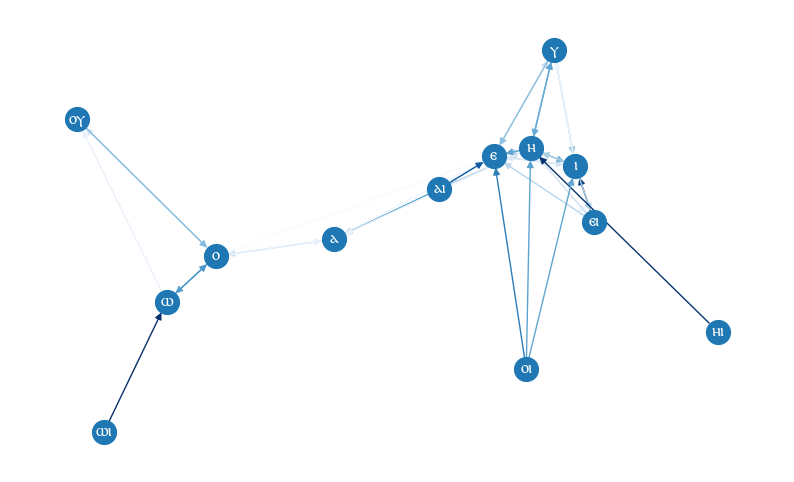

In [529]:
fig = plt.figure(figsize=(10, 6))

graph = nx.from_pandas_edgelist(
    vowel_deviations[vowel_deviations["frequency"] >= 50],
    source="norm",
    target="var",
    edge_attr=["regularity", "frequency"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, weight="frequency", seed=6)

nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(v) for v in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)

fig.savefig(subdirectory / "figure-vowels_graph.svg")
plt.show()

In [215]:
vowel_dates = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"], values=df_diff_vocalic["date_approximate"], aggfunc="median")

dates, frequencies = vowel_dates.align(vowel_frequency, fill_value=np.nan)
vowel_dates = pd.DataFrame(
    np.vectorize(lambda date, frequency: date if frequency >= 5 else np.nan)(dates, frequencies), 
    index=dates.index,
    columns=dates.columns
)
vowel_dates = vowel_dates.loc[vowel_dates.any(axis=1), vowel_dates.any(axis=0)]
write_table(vowel_dates, "vowel_dates", heatmap=True, as_ints=True, caption="Abweichungen bei vokalischen Graphemen: Median-Belegdatum")
vowel_dates.style.background_gradient(axis=None, cmap=cm)

,ⲁ,ⲁⲓ,ⲁⲩ,ⲉ,ⲉⲓ,ⲉⲩ,ⲏ,ⲏⲩ,ⲓ,ⲟ,ⲟⲓ,ⲟⲩ,ⲩ,ⲱ
ⲁ,–,"889,5","624,5","737,0","749,5",–,"849,5",–,"749,5","699,5",–,–,"749,5","824,5"
ⲁⲓ,"637,0",–,–,"862,0","693,2",–,"743,2",–,"832,0","949,5","999,5",–,"889,5",–
ⲁⲩ,"649,5",–,–,–,–,–,–,–,–,–,–,–,–,–
ⲉ,"749,5","887,0",–,–,"680,8",–,"749,5",–,"774,5","837,0","693,2",–,"899,5",–
ⲉⲓ,"449,5","862,0",–,"699,5",–,–,"649,5",–,"724,5",–,"837,0",–,"699,5",–
ⲉⲩ,–,"862,0",–,"887,0",–,–,"649,5","599,5",–,"701,8",–,"949,5","618,2",–
ⲏ,"749,5","724,5",–,"774,5","699,5","905,8",–,"399,5","849,5","849,5","849,5","624,5","912,0","649,5"
ⲏⲓ,–,–,–,–,–,–,"749,5",–,"855,8",–,–,–,"974,5",–
ⲓ,"649,5","824,5",–,"749,5","749,5",–,"889,5",–,–,"887,0","749,5","599,5","887,0","774,5"
ⲟ,"899,5",–,–,"862,0",–,–,"862,0",–,"749,5",–,"349,5","787,0","899,5","887,0"


In [216]:
deviation_frequency = pd.crosstab(df_diff_vocalic["deviation"], df_diff_vocalic["date_approximate"] // 100)
vowel_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["date_approximate"] // 100 == d]["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs} for d in range(15)})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    return row.div(vowel_occurrence_by_dialect.loc[norm])

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by=7, ascending=False).style.background_gradient(axis=None, cmap=cm)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
deviation,,,,,,,,,,,,,,,
ⲱⲓ→ⲱ,–,–,–,"96,8","83,7","50,0","50,0","100,0","83,3","37,5","100,0","78,6","75,0",–,–
ⲏⲓ→ⲏ,–,–,–,"100,0","100,0",–,"44,4","80,0","47,1","20,0","100,0",–,–,–,–
ⲉⲓ→ⲓ,–,–,"68,2","63,3","66,4","61,5","57,1","46,8","56,0","60,3","32,1","59,8","61,4",–,–
ⲟⲓ→ⲉ,–,–,"0,0","6,2","4,3","13,0","18,0","33,6","27,1","6,2","0,0","0,0",–,–,–
ⲁⲓ→ⲉ,–,–,"4,8","21,7","29,8","35,6","29,1","16,7","24,2","36,5","6,7","74,6","69,4",–,–
ⲟⲓ→ⲏ,–,–,"0,0","0,0","4,3","0,0","9,2","12,7","2,9","2,5","0,0","0,0",–,–,–
ⲱ→ⲟ,–,–,"12,0","3,1","2,6","8,1","9,5","10,0","10,0","6,1","20,0","9,9","18,2",–,–
ⲏⲓ→ⲓ,–,–,–,"0,0","0,0",–,"22,2","10,0","41,2","40,0","0,0",–,–,–,–
ⲩ→ⲏ,–,–,"0,0","2,9","1,3","12,6","6,7","9,3","6,1","6,2","14,9","8,2","5,7",–,–


### Consonantal Deviations

In [217]:
df_diff_consonantal = df_diff[df_diff["norm"].isin(consonants) & df_diff["var"].isin(consonants)]
consonant_frequency = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"])
consonant_frequency = consonant_frequency.loc[consonant_frequency.any(axis=1), consonant_frequency.any(axis=0)]
write_table(consonant_frequency, "consonant_frequency", heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Häufigkeit")
consonant_frequency.style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
norm,,,,,,,,,,,,,,,,,,,,,,,
ϩ,69,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
ⲃ,0,22,0,0,0,0,0,0,0,0,1,0,16,1,0,30,0,0,0,0,0,0,0
ⲅ,0,0,1,0,15,0,0,0,2,0,801,2,2,212,0,1,3,0,2,2,3,0,0
ⲇ,0,0,0,8,0,1,1,0,0,0,0,0,0,13,0,0,0,6,1465,0,1,0,0
ⲍ,0,0,0,0,0,0,0,4,0,0,0,0,0,0,6,0,0,148,3,0,0,1,0
ⲑ,0,0,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,1,31,0,1,0,0
ⲕ,0,0,2,0,189,0,478,0,1,0,0,3,0,2,9,6,6,0,1,0,44,0,0
ⲗ,0,0,0,0,0,0,1,0,1,0,2,0,0,13,0,0,88,0,2,0,0,0,0
ⲙ,0,0,0,0,0,11,0,1,0,3,1,1,0,118,0,6,0,1,7,0,0,0,0


In [218]:
consonant_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in consonants})


In [219]:
# Make a copy to avoid modifying original
norm_confusion = consonant_frequency.copy()

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in consonant_occurrences:
        total = consonant_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

/tmp/ipykernel_421023/3022419781.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01763803680981595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_421023/3022419781.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0023006134969325155' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_421023/3022419781.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0002556237218813906' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[graphem

In [220]:
#distance_matrix = 1 - sym_norm_confusion.values
#distance_matrix = -np.log(sym_norm_confusion.values + 0.001)
#distance_matrix = (1 - sym_norm_confusion.values) ** 3
distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)
distance_matrix[np.isnan(distance_matrix)] = 1

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix

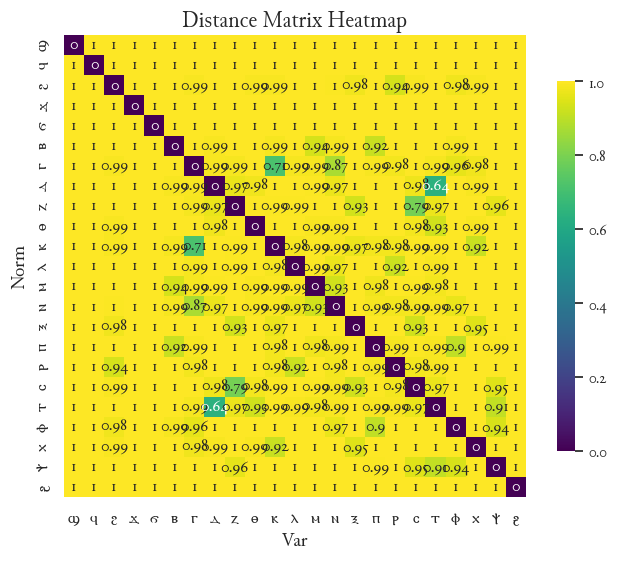

In [221]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

/tmp/ipykernel_421023/980419654.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


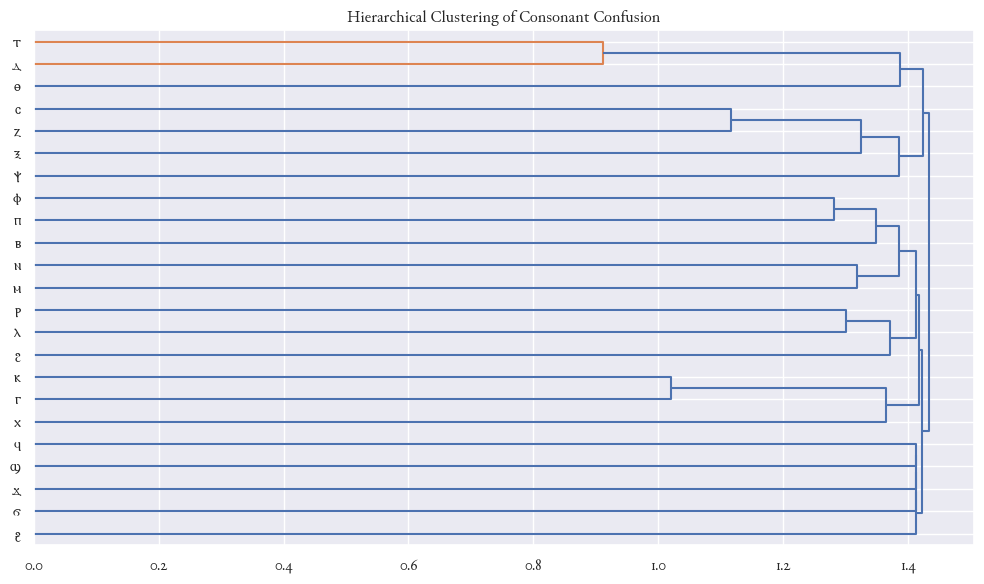

In [222]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Consonant Confusion")
plt.tight_layout()
plt.show()

In [223]:
consonant_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in consonants})
consonant_regularity = 100 * consonant_frequency.div(consonant_occurrences, axis="rows").fillna(0)
consonant_regularity = consonant_regularity.loc[consonant_regularity.any(axis=1), consonant_regularity.any(axis=0)]
write_table(consonant_regularity, "consonant_regularity", heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Regelmäßigkeit")
consonant_regularity.style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
ϩ,"1,8","0,0","0,0","0,2","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1"
ⲃ,"0,0","1,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,7","0,0","0,0","1,3","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
ⲅ,"0,0","0,0","0,0","0,0","0,2","0,0","0,0","0,0","0,0","0,0","11,8","0,0","0,0","3,1","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
ⲇ,"0,0","0,0","0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,2","0,0","0,0","0,0","0,1","21,3","0,0","0,0","0,0","0,0"
ⲍ,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,2","0,0","0,0","0,0","0,0","0,0","0,0","0,3","0,0","0,0","8,6","0,2","0,0","0,0","0,1","0,0"
ⲑ,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,7","0,0","0,0","0,0","0,0"
ⲕ,"0,0","0,0","0,0","0,0","1,8","0,0","4,5","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,1","0,1","0,0","0,0","0,0","0,4","0,0","0,0"
ⲗ,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0","0,8","0,0","0,0","0,0","0,0","0,0","0,0"
ⲙ,"0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,9","0,0","0,0","0,0","0,0","0,1","0,0","0,0","0,0","0,0"
ⲛ,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"


In [224]:
deviation_frequency = pd.crosstab(df_diff_consonantal["deviation"], df_diff_consonantal["dialect_group"])
consonant_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["dialect_group"] == d]["greek_lemma"].str.count(x).sum() for x in consonants} for d in dialects})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    occurrence = consonant_occurrence_by_dialect.loc[norm]
    return row.div(occurrence)

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by="S", ascending=False).style.background_gradient(axis=None, cmap=cm)

dialect_group,B,F,M,S,L,A
deviation,,,,,,
ⲇ→ⲧ,"6,2","20,4","3,3","23,6","11,8","59,3"
ⲅ→ⲕ,"2,2","17,5","0,8","13,0","5,2","3,4"
ⲍ→ⲥ,"7,7","30,6","15,8","7,0","2,6","8,0"
ⲕ→ⲅ,"4,1","2,1","3,8","4,9","0,9","0,0"
ⲧ→ⲇ,"5,2","3,6","0,0","4,7","6,4","0,0"
ⲅ→ⲛ,"2,4","8,1","4,8","2,9","1,9","0,0"
ⲯ→ⲧ,"0,0","0,0","0,0","2,2","0,0","0,0"
ⲫ→ⲡ,"1,9","2,9","0,0","1,7","0,0","0,0"
ϩ→ϣ,"0,0","0,0","0,0","1,7","13,0","0,0"


In [225]:
deviation_frequency.sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)

dialect_group,B,F,M,S,L,A
deviation,,,,,,
ⲇ→ⲧ,23,83,7,1264,56,32
ⲅ→ⲕ,13,69,1,706,11,1
ⲧ→ⲇ,45,22,0,580,19,0
ⲕ→ⲅ,21,15,7,432,3,0
ⲅ→ⲛ,14,32,6,156,4,0
ⲕ→ϭ,0,4,52,124,7,2
ⲣ→ϩ,0,4,8,115,8,3
ⲙ→ⲛ,4,4,0,106,0,4
ⲍ→ⲥ,7,19,24,95,1,2


In [226]:
all_consonant_regularities = pd.DataFrame(consonant_regularity.stack()).reset_index().rename(columns={"level_0": "norm", "norm": "var", 0: "regularity"})
all_consonant_frequencies  = pd.DataFrame(consonant_frequency.stack()).reset_index().rename(columns={0: "frequency"})
consonant_deviations = pd.merge(all_consonant_regularities, all_consonant_frequencies, on=["norm", "var"])
write_csv(consonant_deviations, "deviations-consonants")

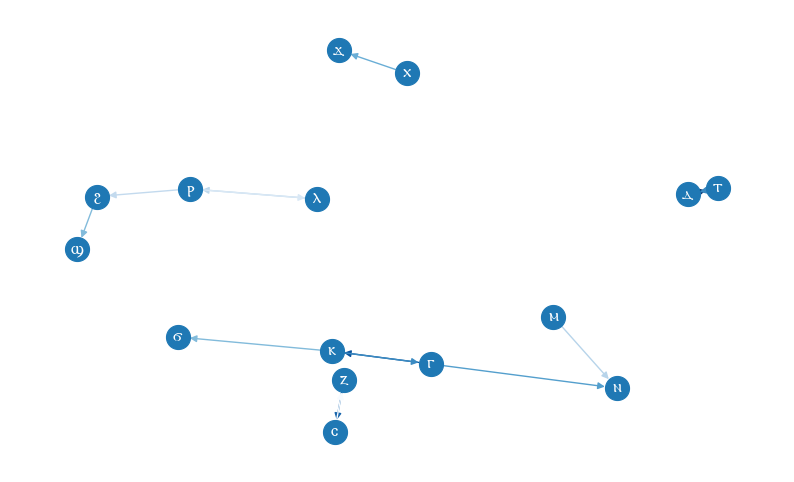

In [530]:
graph = nx.from_pandas_edgelist(
    consonant_deviations[consonant_deviations["frequency"] >= 50],
    source="norm",
    target="var",
    edge_attr=["frequency", "regularity"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, k=2.2, weight="frequency", seed=342)

fig = plt.figure(figsize=(10, 6))
nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(r) for r in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)
fig.savefig(subdirectory / "figure-consonants_graph.svg")
plt.show()

In [228]:
consonant_dates = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"], values=df_diff_consonantal["date_approximate"], aggfunc="median")

dates, frequencies = consonant_dates.align(consonant_frequency, fill_value=np.nan)
consonant_dates = pd.DataFrame(
    np.vectorize(lambda date, frequency: date if frequency >= 5 else np.nan)(dates, frequencies), 
    index=dates.index,
    columns=dates.columns
)
consonant_dates = consonant_dates.loc[consonant_dates.any(axis=1), consonant_dates.any(axis=0)]
write_table(consonant_dates, "consonant_dates", as_ints=True, heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Median-Belegdatum")
consonant_dates.style.background_gradient(axis=None, cmap=cm)

var,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ
norm,,,,,,,,,,,,,,,,,,,,,
ϩ,–,–,"349,5",–,–,–,–,–,–,–,–,–,–,–,–,–,–,–,–,–,–
ⲃ,"819,5",–,–,–,–,–,–,–,–,–,–,"349,5",–,–,"699,5",–,–,–,–,–,–
ⲅ,–,–,–,"649,5",–,–,–,–,–,"824,5",–,–,"774,5",–,–,–,–,–,–,–,–
ⲇ,–,–,"599,5",–,–,–,–,–,–,–,–,–,"449,5",–,–,–,"349,5","737,0",–,–,–
ⲍ,–,–,–,–,–,–,–,–,–,–,–,–,–,"862,0",–,–,"762,0",–,–,–,–
ⲑ,–,–,–,–,–,–,–,–,–,–,–,–,–,–,–,–,–,"649,5",–,–,–
ⲕ,–,–,–,"449,5",–,"899,5",–,–,–,–,–,–,–,"649,5","749,5","349,5",–,–,–,"874,5",–
ⲗ,–,–,–,–,–,–,–,–,–,–,–,–,"974,5",–,–,"899,5",–,–,–,–,–
ⲙ,–,–,–,–,"774,5",–,–,–,–,–,–,–,"887,0",–,"412,0",–,–,"643,2",–,–,–


In [229]:
deviation_frequency = pd.crosstab(df_diff_consonantal["deviation"], df_diff_consonantal["date_approximate"] // 100)
consonant_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["date_approximate"] // 100 == d]["greek_lemma"].str.count(x).sum() for x in consonants} for d in range(15)})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    return row.div(consonant_occurrence_by_dialect.loc[norm])

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by=7, ascending=False).style.background_gradient(axis=None, cmap=cm)
#.head(10).transpose().plot.line()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
deviation,,,,,,,,,,,,,,,
ⲇ→ⲧ,–,–,"6,6","16,1","20,5","28,3","22,4","23,2","19,4","16,9","36,2","2,9","11,8",–,–
ⲍ→ⲥ,–,–,"14,3","2,7","1,9","21,4","21,5","18,3","4,6","8,6","16,7","0,0","0,0",–,–
ⲅ→ⲕ,–,–,"23,1","5,5","5,4","11,7","14,2","11,2","13,8","15,2","19,8","1,9","0,0",–,–
ⲧ→ⲇ,–,–,"6,2","0,2","1,0","6,6","3,3","5,0","7,0","5,1","2,2","5,2","4,5",–,–
ⲅ→ⲛ,–,–,"7,7","1,2","2,5","1,7","3,0","4,8","3,6","2,4","6,2","0,0","0,0",–,–
ⲕ→ⲅ,–,–,"0,0","3,0","3,8","8,9","5,0","4,3","10,1","3,8","1,8","2,3","15,9",–,–
ⲝ→ⲥ,–,–,"0,0","0,0","0,0","0,0","6,2","3,1","0,0","0,0","0,0","0,0","0,0",–,–
ⲑ→ⲧ,–,–,"0,0","1,5","0,8","1,1","2,2","2,2","0,2","0,0","0,0","0,0","0,0",–,–
ⲙ→ⲛ,–,–,"0,0","0,5","0,5","1,1","0,6","1,3","1,1","0,9","0,5","0,0","0,0",–,–


# Playground

In [230]:
df_simple

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters
id,,,,,,,,,,,
30,[ⲁⲣ]ⲛⲁ,ⲁⲣⲛⲉⲟⲙⲁⲓ,L,249.5,299.0,200.0,"(200.0, 299.0)",Cambridge - Bible Society's Library pap. Q - G...,3.0,ⲁⲣⲛⲁ,{}
71613,ⲇⲉ,ⲇⲉ,L,249.5,299.0,200.0,"(200.0, 299.0)",Cambridge - Bible Society's Library pap. Q - G...,3.0,ⲇⲉ,{}
71614,ⲡⲁⲥⲭⲁ,ⲡⲁⲥⲭⲁ,L,249.5,299.0,200.0,"(200.0, 299.0)",Cambridge - Bible Society's Library pap. Q - G...,3.0,ⲡⲁⲥⲭⲁ,{}
71615,ⲓⲟⲩⲧⲁⲉⲓ,ⲓⲟⲩⲇⲁⲓⲟⲥ,L,249.5,299.0,200.0,"(200.0, 299.0)",Cambridge - Bible Society's Library pap. Q - G...,3.0,ⲓⲟⲩⲧⲁⲉⲓ,{}
71616,[ⲧⲣⲁ|ⲡⲉ]ⲍⲓⲧⲏⲥ,ⲧⲣⲁⲡⲉⲍⲓⲧⲏⲥ,L,249.5,299.0,200.0,"(200.0, 299.0)",Cambridge - Bible Society's Library pap. Q - G...,3.0,ⲧⲣⲁⲡⲉⲍⲓⲧⲏⲥ,{}
...,...,...,...,...,...,...,...,...,...,...,...
201060,ⲙⲟⲙⲟⲕⲉⲣⲱⲥ,ⲙⲟⲛⲟⲕⲉⲣⲱⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Nagel 2022b - - Psalms,NaN,ⲙⲟⲙⲟⲕⲉⲣⲱⲥ,{}
201061,ⲕⲁⲑⲩⲡⲟⲧⲁⲥⲥⲉ,ⲕⲁⲑⲩⲡⲟⲧⲁⲥⲥⲱ,S,709.5,719.0,700.0,"(700.0, 719.0)",Khartum - National Museum 24338 - Foundation i...,8.0,ⲕⲁⲑⲩⲡⲟⲧⲁⲥⲥⲉ,{}
201062,ⲡⲣⲟⲉⲇⲣⲟⲥ,ⲡⲣⲟⲉⲇⲣⲟⲥ,S,709.5,719.0,700.0,"(700.0, 719.0)",Khartum - National Museum 24338 - Foundation i...,8.0,ⲡⲣⲟⲉⲇⲣⲟⲥ,{}


In [231]:
vowel = ("ⲁ", "ⲉ", "ⲓ", "ⲟ", "ⲩ", "ⲏ", "ⲱ")
vowel_or_spiritus = tuple([*vowel, *map(lambda x: "ϩ" + x, vowel)])

vocalic_initial = df_simple[df_simple["greek_lemma"].str.startswith(vowel_or_spiritus) & df_simple["orthography_clean"].str.startswith(vowel_or_spiritus)]

vocalic_initial = vocalic_initial.assign(
    greek_h=vocalic_initial["greek_lemma"].str.startswith("ϩ"),
    coptic_h=vocalic_initial["orthography_clean"].str.startswith("ϩ")
)
vocalic_initial = vocalic_initial[vocalic_initial["dialect_group"].isin({"B", "S", "F"})]
vocalic_initial["century"] = (vocalic_initial["date_approximate"] // 100)

In [232]:
pattern = re.compile(r"ⲁⲩ|ⲁⲓ|ⲉⲓ|ⲟⲩ|ⲟⲓ|ⲉⲩ|[ⲁⲉⲓⲟⲩⲏⲱ]")

# Function to find the first match
def find_first_vowel(text):
    match = pattern.search(text)
    return match.group(0) if match else None

vocalic_initial["initial_vowel"] = vocalic_initial["greek_lemma"].apply(find_first_vowel)

In [233]:
vocalic_initial

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters,greek_h,coptic_h,initial_vowel
id,,,,,,,,,,,,,,
6958,ⲁⲓⲧⲓⲁ,ⲁⲓⲧⲓⲁ,S,299.5,399.0,200.0,"(200.0, 399.0)",Papyrus Nag Hammadi C 003 - Unknown homily,2.0,ⲁⲓⲧⲓⲁ,{},False,False,ⲁⲓ
6963,[ϩ]ⲟ̣ⲙ̣ⲱ̣ⲥ̣,ϩⲟⲙⲱⲥ,S,299.5,399.0,200.0,"(200.0, 399.0)",Papyrus Nag Hammadi C 004 - Letter from Daniel...,2.0,ϩⲟⲙⲱⲥ,{},True,True,ⲟ
6967,ⲉⲡⲓⲇⲏ,ⲉⲡⲉⲓⲇⲏ,S,299.5,399.0,200.0,"(200.0, 399.0)",Papyrus Nag Hammadi C 004 - Letter from Daniel...,2.0,ⲉⲡⲓⲇⲏ,{},False,False,ⲉ
7062,ⲉⲡⲓⲇⲏ,ⲉⲡⲉⲓⲇⲏ,S,299.5,399.0,200.0,"(200.0, 399.0)",Papyrus Nag Hammadi C 004 - Letter from Daniel...,2.0,ⲉⲡⲓⲇⲏ,{},False,False,ⲉ
7072,[ⲉ]ⲡ̣ⲓ̈ⲇⲏ̣,ⲉⲡⲉⲓⲇⲏ,S,299.5,399.0,200.0,"(200.0, 399.0)",Papyrus Nag Hammadi C 004 - Letter from Daniel...,2.0,ⲉⲡⲓⲇⲏ,{},False,False,ⲉ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201015,ⲉⲝⲱⲣⲅⲓⲥⲙⲉⲛⲟⲥ,ⲉⲝⲟⲣⲅⲓⲍⲱ,S,NaN,NaN,NaN,"(200.0, 1299.0)",New York - The Morgan Library and Museum M.587...,NaN,ⲉⲝⲱⲣⲅⲓⲥⲙⲉⲛⲟⲥ,{},False,False,ⲉ
201016,ϩⲟⲣⲟⲥ,ⲟⲣⲟⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",New York - The Morgan Library and Museum M.587...,NaN,ϩⲟⲣⲟⲥ,{},False,True,ⲟ
201048,ⲉⲡⲓⲥⲕⲟⲡⲟⲥ,ⲉⲡⲓⲥⲕⲟⲡⲟⲥ,S,999.5,1099.0,900.0,"(900.0, 1099.0)",Paris - Bibliothèque Nationale Copte 129.14.1-...,9.0,ⲉⲡⲓⲥⲕⲟⲡⲟⲥ,{},False,False,ⲉ


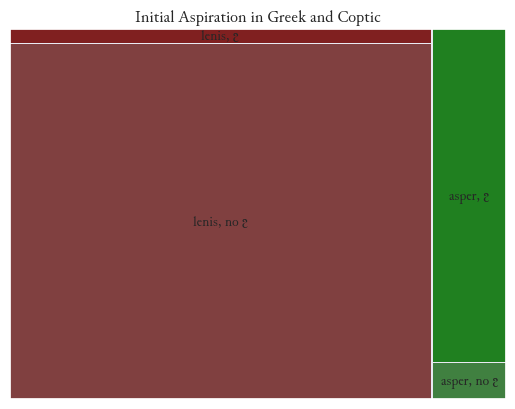

In [234]:
xtab = pd.crosstab(vocalic_initial["greek_h"], vocalic_initial["coptic_h"])

from statsmodels.graphics.mosaicplot import mosaic
mosaic(vocalic_initial, ["greek_h", "coptic_h"], 
       title='Initial Aspiration in Greek and Coptic', 
       labelizer=lambda k: ("asper" if k[0] == "True" else "lenis") + ", " + ("ϩ" if k[1] == "True" else "no ϩ"),
       axes_label=False
      )
plt.show()

In [235]:
agreement = (vocalic_initial['greek_h'] == vocalic_initial['coptic_h']).mean()
agreement

0.9541933310879084

/tmp/ipykernel_421023/417363099.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agreement_proportions = vocalic_initial.groupby(["dialect_group", "century"]).apply(
/tmp/ipykernel_421023/417363099.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_proportions = vocalic_initial.groupby(["dialect_group", "century"]).apply(


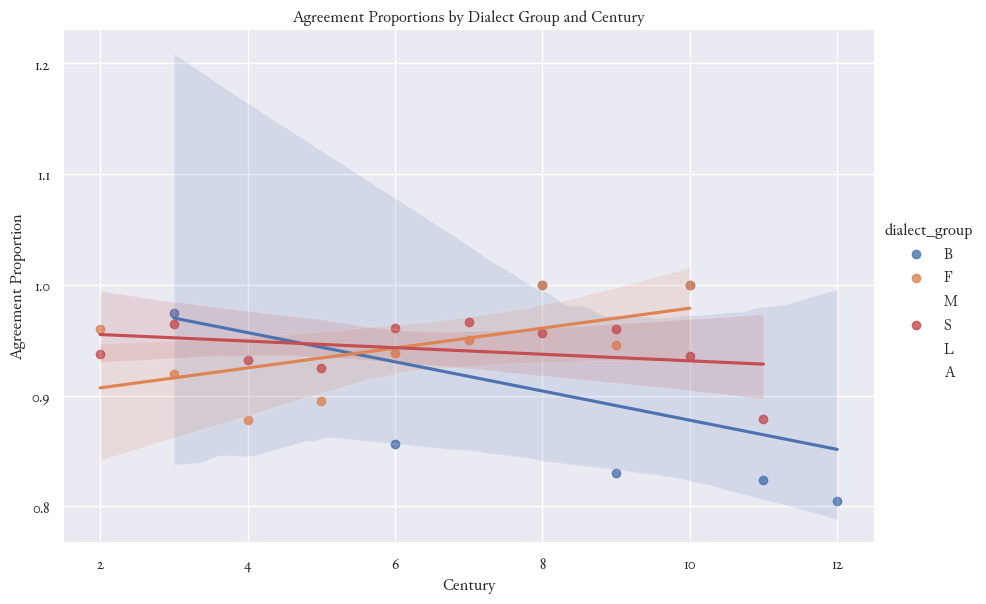

In [236]:
agreement_proportions = vocalic_initial.groupby(["dialect_group", "century"]).apply(
    lambda x: (x["greek_h"] == x["coptic_h"]).mean()
).reset_index(name='agreement_proportion')

# Create the plot using lmplot
sns.lmplot(data=agreement_proportions, x='century', y='agreement_proportion', 
           hue='dialect_group', markers='o', aspect=1.5, height=6)

# Customize the plot
plt.title('Agreement Proportions by Dialect Group and Century')
plt.xlabel('Century')
plt.ylabel('Agreement Proportion')
plt.grid(True)

# Show the plot
plt.show()

# TODO maybe this is due to bohairic using more words like hirēnē later on?

In [239]:
vocalic_initial[vocalic_initial['greek_h'] != vocalic_initial['coptic_h']]["greek_lemma"].unique()

array(['ⲉⲗⲡⲓⲍⲱ', 'ⲉⲗⲡⲓⲥ', 'ⲉⲓ', 'ϩⲁⲣⲙⲁ', 'ϩⲟⲣⲙⲓⲥⲕⲟⲥ', 'ϩⲱⲥ', 'ⲁⲙⲏⲛ',
       'ϩⲁⲅⲓⲟⲥ', 'ⲉⲓⲕⲱⲛ', 'ⲓⲥⲟⲥ', 'ⲉⲑⲛⲟⲥ', 'ϩⲟⲣⲁⲥⲓⲥ', 'ϩⲉⲱⲥ', 'ϩⲟⲥⲟⲥ',
       'ϩⲟⲧⲓ', 'ϩⲓⲛⲁ', 'ϩⲁⲗⲩⲥⲓⲥ', 'ⲓⲥⲁⲅⲅⲉⲗⲟⲥ', 'ⲉⲓⲣⲏⲛⲏ', 'ⲉⲧⲁⲍⲱ',
       'ϩⲩⲡⲁⲣⲭⲱ', 'ⲟⲣⲅⲏ', 'ⲟⲃⲟⲗⲟⲥ', 'ϩⲩⲇⲱⲣ', 'ϩⲟⲙⲟⲩ', 'ϩⲉⲕⲧⲟⲥ', 'ⲁⲣⲁ',
       'ⲏⲇⲏ', 'ϩⲩⲓⲟⲥ', 'ⲉⲛⲛⲉⲁⲥ', 'ⲉⲓⲗⲓⲕⲣⲓⲛⲏⲥ', 'ⲟⲅⲇⲟⲁⲥ', 'ϩⲉⲝⲁⲥ',
       'ϩⲏⲗⲓⲁⲕⲟⲥ', 'ϩⲩⲡⲉⲣⲁⲥⲁⲗⲉⲩⲧⲟⲥ', 'ⲱⲓⲇⲏ', 'ⲓⲇⲓⲟⲥ', 'ⲁⲅⲛⲉⲓⲁ',
       'ϩⲩⲡⲟⲭⲟⲛⲇⲣⲓⲟⲥ', 'ϩⲏⲗⲓⲟⲥ', 'ⲟⲗⲓⲅⲟⲥ', 'ϩⲏⲛⲓⲟⲭⲟⲥ', 'ϩⲉⲗⲗⲉⲃⲟⲣⲟⲥ',
       'ϩⲟⲧⲁⲛ', 'ϩⲉⲣⲙⲏⲛⲉⲩⲱ', 'ⲓⲇⲉⲁ', 'ⲓⲥⲟⲇⲩⲛⲁⲙⲓⲁ', 'ⲓⲥⲟⲭⲣⲟⲛⲟⲥ', 'ⲉⲑⲛⲓⲕⲟⲥ',
       'ⲉⲓⲕⲟⲛⲓⲕⲟⲥ', 'ⲟⲡⲱⲣⲁ', 'ⲓⲥⲟⲇⲩⲛⲁⲙⲟⲥ', 'ϩⲟⲓⲟⲥ', 'ϩⲱⲥⲁⲛⲛⲁ', 'ⲁⲣⲙⲁ',
       'ϩⲓⲉⲣⲁⲧⲓⲕⲟⲥ', 'ⲏⲧⲣⲟⲛ', 'ⲁⲙⲙⲁⲛⲓⲧⲏⲥ', 'ⲉⲑⲟⲥ', 'ϩⲏⲥⲩⲭⲁⲍⲱ', 'ϩⲟⲙⲟⲓⲟⲥ',
       'ϩⲉⲧⲟⲓⲙⲟⲥ', 'ϩⲁⲅⲓⲱⲥⲩⲛⲏ', 'ϩⲁⲡⲗⲱⲥ', 'ϩⲉⲃⲇⲟⲙⲁⲥ', 'ⲁⲛⲁⲗⲱⲙⲁ', 'ⲟⲕⲛⲟⲥ',
       'ⲉⲑⲱ', 'ϩⲉⲯⲏⲙⲁ', 'ϩⲁⲗⲱⲛⲓⲁ', 'ⲓⲇⲓⲱⲧⲏⲥ', 'ⲁⲛⲁⲅⲛⲱⲥⲧⲏⲥ', 'ϩⲟⲙⲟⲗⲟⲅⲓⲁ',
       'ⲓⲁⲧⲣⲟⲥ', 'ϩⲏⲙⲓⲥⲩⲥ', 'ϩⲉⲕⲁⲧⲟⲛ', 'ϩⲉⲝⲏⲕⲟⲛⲧⲁ', 'ϩⲉⲝⲁⲕⲉⲣⲁⲧⲓⲟⲛ',
       'ⲉⲕⲭⲱⲣⲏⲧⲓⲕⲟⲥ', 'ϩⲁⲗⲁⲧⲓⲟⲛ', 'ⲁⲗⲉⲩⲣⲟⲛ', 'ϩⲩⲡⲟⲡⲟⲇⲓⲟⲛ', 'ϩⲟⲥⲓⲟⲥ',
       'ϩⲟⲓⲟⲥⲇⲏⲡⲟⲧⲉ'

/tmp/ipykernel_421023/801895753.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agreement_proportions = vocalic_initial.groupby(["dialect_group", "initial_vowel"]).apply(
/tmp/ipykernel_421023/801895753.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_proportions = vocalic_initial.groupby(["dialect_group", "initial_vowel"]).apply(


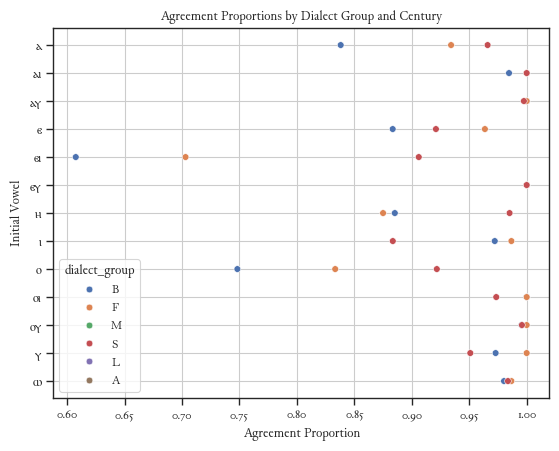

In [359]:
agreement_proportions = vocalic_initial.groupby(["dialect_group", "initial_vowel"]).apply(
    lambda x: (x["greek_h"] == x["coptic_h"]).mean()
).reset_index(name='agreement_proportion')

# Create the plot using lmplot
sns.scatterplot(data=agreement_proportions, y='initial_vowel', x='agreement_proportion', hue="dialect_group", markers='o')

# Customize the plot
plt.title('Agreement Proportions by Dialect Group and Century')
plt.ylabel('Initial Vowel')
plt.xlabel('Agreement Proportion')
plt.grid(True)

# Show the plot
plt.show()


In [241]:
vocalic_initial[vocalic_initial["greek_h"] != vocalic_initial["coptic_h"]].groupby("greek_lemma")["dialect_group"].value_counts().unstack().sort_values(by="S", ascending=False)

dialect_group,B,F,M,S,L,A
greek_lemma,,,,,,
ⲁⲙⲏⲛ,0,28,0,620,0,0
ⲉⲑⲛⲟⲥ,1,0,0,332,0,0
ⲉⲓⲕⲱⲛ,11,8,0,201,0,0
ⲉⲗⲡⲓⲥ,22,3,0,111,0,0
ϩⲟⲙⲟⲓⲟⲥ,6,0,0,90,0,0
...,...,...,...,...,...,...
ϩⲟⲣⲙⲓⲥⲕⲟⲥ,0,1,0,0,0,0
ϩⲟⲙⲟⲟⲩⲥⲓⲟⲥ,7,0,0,0,0,0
ϩⲁⲙⲁ,3,0,0,0,0,0


In [242]:
vocalic_initial[vocalic_initial["dialect_group"] == "B"][vocalic_initial["initial_vowel"] == "ⲁ"][vocalic_initial["greek_h"] != vocalic_initial["coptic_h"]]

/tmp/ipykernel_421023/1729616361.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vocalic_initial[vocalic_initial["dialect_group"] == "B"][vocalic_initial["initial_vowel"] == "ⲁ"][vocalic_initial["greek_h"] != vocalic_initial["coptic_h"]]
/tmp/ipykernel_421023/1729616361.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vocalic_initial[vocalic_initial["dialect_group"] == "B"][vocalic_initial["initial_vowel"] == "ⲁ"][vocalic_initial["greek_h"] != vocalic_initial["coptic_h"]]


,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters,greek_h,coptic_h,initial_vowel
id,,,,,,,,,,,,,,
172936,ⲁⲅⲓⲟⲥ,ϩⲁⲅⲓⲟⲥ,B,699.5,719.0,680.0,"(680.0, 719.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,6.0,ⲁⲅⲓⲟⲥ,{},True,False,ⲁ
175653,ⲁⲡⲗⲱⲥ,ϩⲁⲡⲗⲱⲥ,B,699.5,719.0,680.0,"(680.0, 719.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,6.0,ⲁⲡⲗⲱⲥ,{},True,False,ⲁ
180958,Ⲁⲡⲗⲱⲥ,ϩⲁⲡⲗⲱⲥ,B,699.5,719.0,680.0,"(680.0, 719.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,6.0,ⲁⲡⲗⲱⲥ,{},True,False,ⲁ
180969,ⲁⲡⲗⲱⲥ,ϩⲁⲡⲗⲱⲥ,B,699.5,719.0,680.0,"(680.0, 719.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,6.0,ⲁⲡⲗⲱⲥ,{},True,False,ⲁ
182293,Ⲁⲡⲁⲝ,ϩⲁⲡⲁⲝ,B,699.5,719.0,680.0,"(680.0, 719.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,6.0,ⲁⲡⲁⲝ,{},True,False,ⲁ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118769,ⲁ̄ⲅⲓⲟⲥ,ϩⲁⲅⲓⲟⲥ,B,NaN,NaN,NaN,"(200.0, 1299.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,NaN,ⲁⲅⲓⲟⲥ,{},True,False,ⲁ
118854,ⲁⲅⲓⲁ,ϩⲁⲅⲓⲟⲥ,B,NaN,NaN,NaN,"(200.0, 1299.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,NaN,ⲁⲅⲓⲁ,{},True,False,ⲁ
119603,ⲁⲅⲓⲁⲍⲓⲛ,ϩⲁⲅⲓⲁⲍⲱ,B,NaN,NaN,NaN,"(200.0, 1299.0)",Rome - Vatican - Biblioteca del Vaticano Vat. ...,NaN,ⲁⲅⲓⲁⲍⲓⲛ,{},True,False,ⲁ


## Diachronic study

<Axes: >

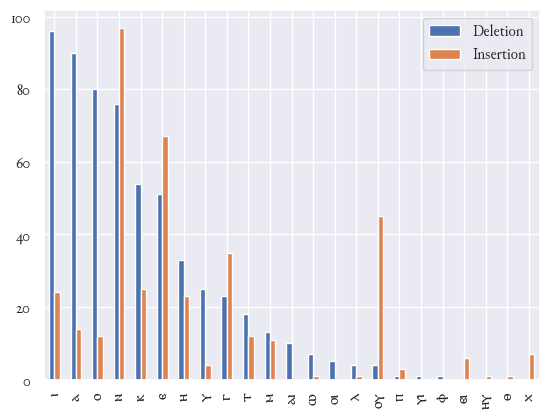

In [245]:
unique_by_orthography = df_diff_well_dated

deletions = unique_by_orthography[(unique_by_orthography["var"] == "∅") & (unique_by_orthography["context_left"] != "#") & (unique_by_orthography["context_left"] != "#")]
insertions = unique_by_orthography[(unique_by_orthography["norm"] == "∅") & (unique_by_orthography["context_left"] != "#") & (unique_by_orthography["context_left"] != "#")]

interesting = (vowels | diphthongs | consonants) - {"ϩ", "ⲥ", "ⲣ"}

pd.DataFrame({
    "Deletion": deletions[deletions["norm"].isin(interesting)]["norm"].value_counts(),
    "Insertion": insertions[insertions["var"].isin(interesting)]["var"].value_counts()
}).sort_values("Deletion", ascending=False).plot.bar(logy=False)

In [246]:
interesting_insertions = insertions[insertions["var"].isin(interesting)]
pd.crosstab(interesting_insertions["var"], interesting_insertions["date_approximate"] // 100).style.background_gradient(axis=None, cmap=cm)

date_approximate,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
var,,,,,,,,,,,
ⲁ,0,0,0,1,0,7,2,4,0,0,0
ⲅ,1,19,4,1,1,1,5,0,1,1,1
ⲉ,2,5,5,4,18,15,11,6,1,0,0
ⲉⲓ,0,3,0,0,0,3,0,0,0,0,0
ⲏ,0,2,1,0,8,4,2,6,0,0,0
ⲏⲩ,0,0,0,0,0,1,0,0,0,0,0
ⲑ,0,0,0,0,0,0,1,0,0,0,0
ⲓ,1,2,0,1,3,3,6,5,1,0,2
ⲕ,1,0,6,1,3,4,5,5,0,0,0


In [247]:
interesting_insertions[interesting_insertions['var'].isin(vowels)].apply(lambda x: x["earliest"] > 800, axis=1).value_counts()

False    95
True     50
Name: count, dtype: int64

<Axes: >

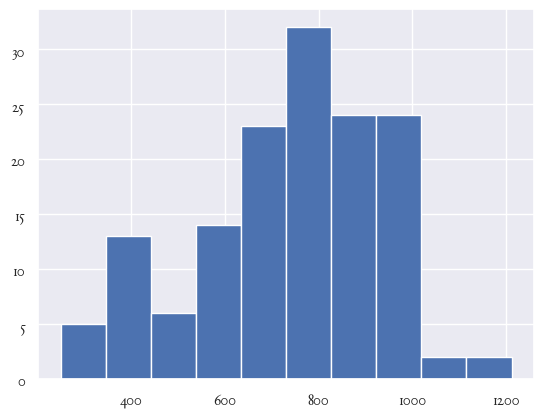

In [248]:
insertions[insertions["var"].isin(vowels)]["date_approximate"].hist()

In [249]:
# Group by both 'greek_lemma' and 'dialect_group' to get the minimum date
date_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()

# Count deviations per lemma and dialect group
deviations_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Count attestations per lemma and dialect group
attestations_per_lemma = df_simple.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Create a DataFrame with the results
per_lemma = pd.DataFrame({
    "earliest_attestation": date_per_lemma,
    "deviations": deviations_per_lemma,
    "attestations": attestations_per_lemma
}).dropna()

# Calculate the deviation rate
per_lemma["deviation_rate"] = per_lemma["deviations"].div(per_lemma["attestations"])

# Reset index to make 'greek_lemma' and 'dialect_group' columns
per_lemma = per_lemma.reset_index()
per_lemma

/tmp/ipykernel_421023/1887153394.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()
/tmp/ipykernel_421023/1887153394.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deviations_per_lemma = df_diff_well_dated.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()
/tmp/ipykernel_421023/1887153394.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

,greek_lemma,dialect_group,earliest_attestation,deviations,attestations,deviation_rate
0,ϩⲁⲅⲁⲣⲓⲛⲛⲁⲓⲟⲥ,B,1212.0,2.0,1,2.000000
1,ϩⲁⲅⲓⲁⲍⲱ,S,949.5,3.0,18,0.166667
2,ϩⲁⲅⲓⲟⲥ,B,699.5,31.0,178,0.174157
3,ϩⲁⲅⲓⲟⲥ,S,649.5,6.0,943,0.006363
4,ϩⲁⲅⲓⲱⲥⲩⲛⲏ,S,612.0,14.0,31,0.451613
...,...,...,...,...,...,...
2302,ⲱⲕⲉⲁⲛⲟⲥ,S,949.5,3.0,10,0.300000
2303,ⲱⲙⲟⲫⲟⲣⲟⲥ,L,404.0,1.0,10,0.100000
2304,ⲱⲛⲏⲙⲁ,S,749.5,2.0,1,2.000000
2305,ⲱⲫⲉⲗⲉⲱ,S,699.5,6.0,65,0.092308


SignificanceResult(statistic=-0.08560549184198107, pvalue=3.837216634107027e-05)

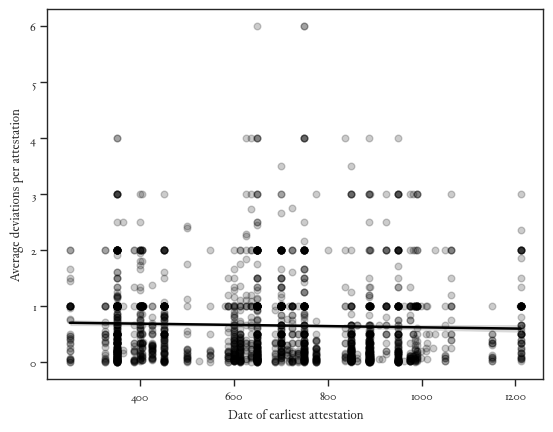

In [538]:
sns.regplot(x="earliest_attestation", y="deviation_rate", data=per_lemma, scatter_kws={'alpha':0.2}, color="black")
plt.ylabel("Average deviations per attestation")
plt.xlabel("Date of earliest attestation")
write_figure("deviation_rate_by_earliest_attestation")
scipy.stats.spearmanr(per_lemma["earliest_attestation"], per_lemma["deviation_rate"])

In [251]:
import math
interesting = vowels | diphthongs | consonants | {"∅"}

sound_frequency = {x: df_diff["greek_lemma"].str.count(x).sum() for x in interesting}
def func(group): 
    norm = group["norm"].unique()[0]
    if sound_frequency[norm] == 0:
        return 0.01
    else:
        return group.shape[0] / sound_frequency[norm]

def classify_deviation(deviation):
    norm, var = deviation.split("→")
    return {"norm": norm, "var": var}

sounds_affected = df_diff[df_diff["norm"].isin(interesting)].groupby("deviation").apply(func)
words_affected = df_diff.groupby("deviation")["greek_lemma"].unique().apply(len)#.apply(math.log10)
absolute_frequency = df_diff.groupby("deviation")["deviation"].apply(len)
relative_frequency_df = pd.DataFrame(words_affected.rename("Word rate")).join(sounds_affected.rename("Sound rate")).join(absolute_frequency.rename("Absolute frequency"))
relative_frequency_df["Word spread"] = relative_frequency_df["Word rate"].div(relative_frequency_df["Absolute frequency"])
relative_frequency_df["Score"] = relative_frequency_df["Word rate"].mul(relative_frequency_df["Sound rate"])
relative_frequency_df = relative_frequency_df[~relative_frequency_df.index.isin(morphological_lapsus)]
relative_frequency_df[['shift_class', 'shift_origin']] = pd.DataFrame(
    relative_frequency_df.index.map(classify_deviation).tolist(), 
    index=relative_frequency_df.index
)


/tmp/ipykernel_421023/1374619051.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sounds_affected = df_diff[df_diff["norm"].isin(interesting)].groupby("deviation").apply(func)


In [252]:
relative_frequency_df[~relative_frequency_df["shift_class"].isnull()].sort_values(by="Score", ascending=False)#["class"]#.value_counts()

,Word rate,Sound rate,Absolute frequency,Word spread,Score,shift_class,shift_origin
deviation,,,,,,,
ⲉⲓ→ⲓ,196,0.594507,4784,0.040970,116.523425,ⲉⲓ,ⲓ
ⲇ→ⲧ,201,0.212967,1465,0.137201,42.806367,ⲇ,ⲧ
ⲁⲓ→ⲉ,119,0.317614,1448,0.082182,37.796008,ⲁⲓ,ⲉ
ⲟ→ⲱ,459,0.060241,1953,0.235023,27.650432,ⲟ,ⲱ
ⲅ→ⲕ,221,0.117916,801,0.275905,26.059326,ⲅ,ⲕ
...,...,...,...,...,...,...,...
ⲱⲥ→∅,1,NaN,1,1.000000,NaN,ⲱⲥ,∅
ⲱⲥ→ⲟⲩ,1,NaN,1,1.000000,NaN,ⲱⲥ,ⲟⲩ
ⲱⲥⲓⲥ→∅,1,NaN,3,0.333333,NaN,ⲱⲥⲓⲥ,∅


/tmp/ipykernel_421023/3514902429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  greek_tokens_per_century = (df_diff.groupby('dialect_group')['century']).value_counts()


dialect_group  century
B              10.0       432
               7.0        338
               4.0        301
               13.0       273
               12.0       184
                         ... 
A              9.0          0
               10.0         0
               11.0         0
               12.0         0
               13.0         0
Name: count, Length: 66, dtype: int64

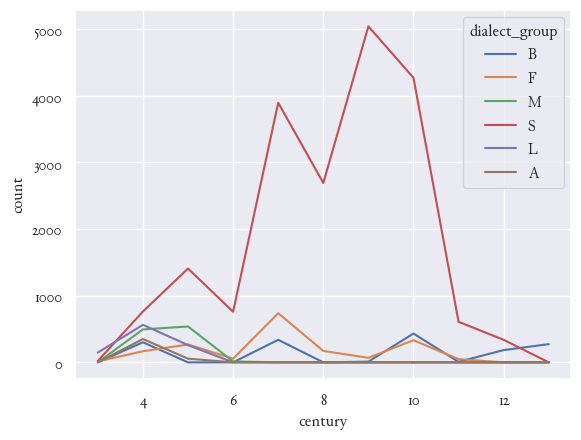

In [253]:
greek_tokens_per_century = (df_diff.groupby('dialect_group')['century']).value_counts()
sns.lineplot(greek_tokens_per_century.reset_index(), x="century", hue="dialect_group", y="count")
greek_tokens_per_century

In [254]:
interesting_dialects = {"S", "B", "F"}

deviations = df_diff_well_dated.groupby(['dialect_group', 'century', 'shift_class', 'shift_origin']).size().reset_index(name='deviation_count')
deviations = deviations.merge(greek_tokens_per_century.rename("greek_token_count"), on=["dialect_group", "century"])
deviations["deviation_count_relative"] = deviations["deviation_count"].div(deviations["greek_token_count"])
deviations = deviations.dropna()
deviations.sample(10)

/tmp/ipykernel_421023/4098691032.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deviations = df_diff_well_dated.groupby(['dialect_group', 'century', 'shift_class', 'shift_origin']).size().reset_index(name='deviation_count')


,dialect_group,century,shift_class,shift_origin,deviation_count,greek_token_count,deviation_count_relative
834,S,4.0,reduction,greek,0,763,0.000000
237,B,12.0,spirantisation,nongreek,0,184,0.000000
968,S,10.0,gemination,greek,0,4268,0.000000
1067,L,3.0,lambdacism,nongreek,0,147,0.000000
880,S,6.0,palatalisation,greek,0,759,0.000000
986,S,11.0,back_vowel,greek,41,608,0.067434
582,M,5.0,front_vowel,greek,64,538,0.118959
830,S,4.0,nasal,greek,0,763,0.000000
840,S,5.0,aspiration,greek,0,1407,0.000000
1116,L,5.0,monophthongization,greek,21,258,0.081395


In [255]:
deviations['shift_class'].value_counts()

shift_class
aspiration            68
back_vowel            68
epenthesis            68
front_vowel           68
gemination            68
lambdacism            68
monophthongization    68
nasal                 68
palatalisation        68
reduction             68
spirantisation        68
voiced_voiceless      68
Name: count, dtype: int64

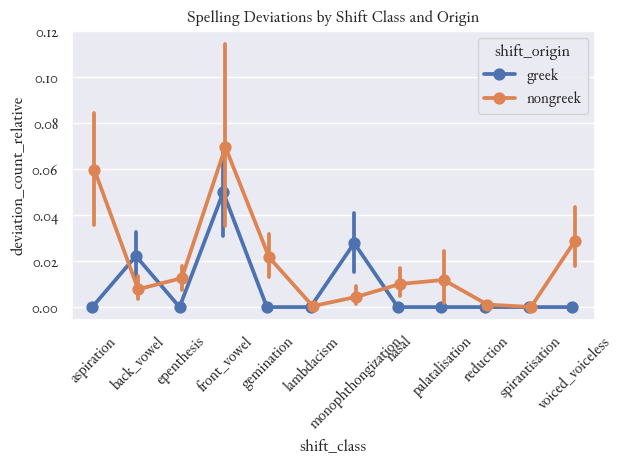

In [256]:
sns.pointplot(
    data=deviations,
    x="shift_class",
    y="deviation_count_relative",
    hue="shift_origin",
    dodge=True
)
plt.xticks(rotation=45)
plt.title("Spelling Deviations by Shift Class and Origin")
plt.tight_layout()
plt.show()


<Axes: xlabel='date_approximate', ylabel='Count'>

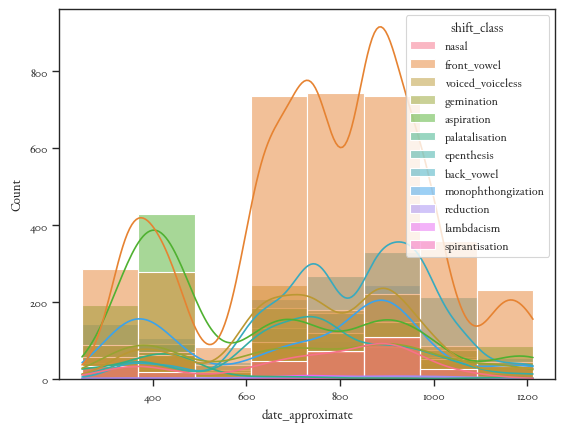

In [543]:
sns.histplot(df_diff_well_dated, x="date_approximate", hue="shift_class", kde=True, bins=8)

<Figure size 1000x600 with 0 Axes>

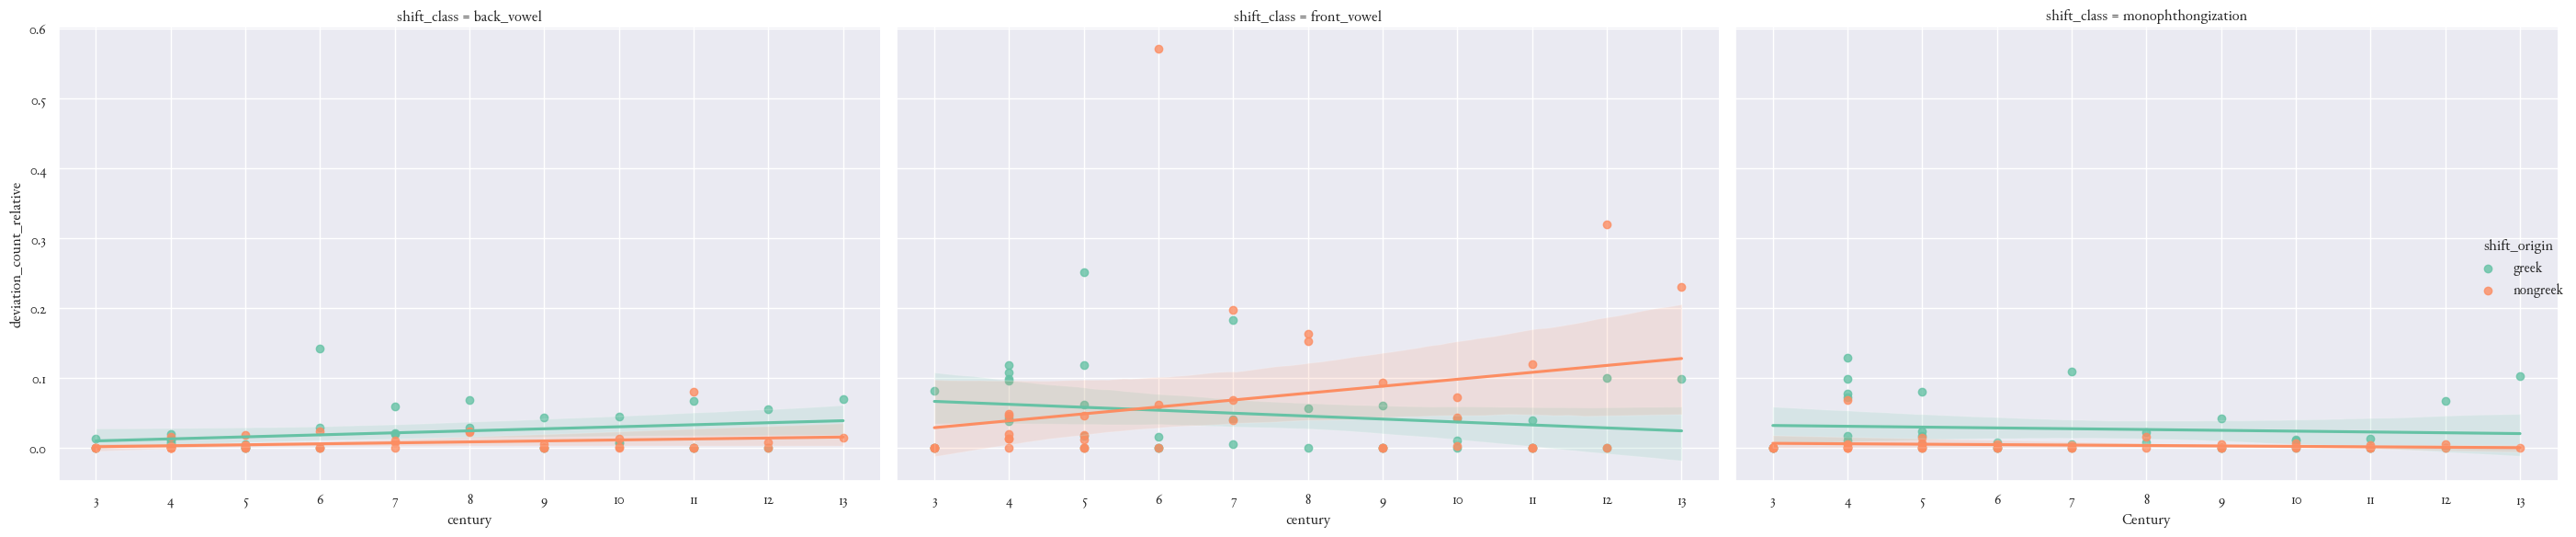

In [257]:

plt.figure(figsize=(10, 6))
sns.lmplot(data=deviations[deviations["shift_class"].isin({"monophthongization", "front_vowel", "back_vowel"})], x='century', y='deviation_count_relative', hue='shift_origin',
           markers='o', aspect=1.5, height=6, palette='Set2', col='shift_class')

#plt.yscale('log')
plt.xlabel("Century")
plt.ylabel("Frequency")
plt.xticks(deviations['century'].unique())  # Ensure all centuries are shown on the x-axis
plt.tight_layout()
plt.show()

## Spelling of common words is more consistent

/tmp/ipykernel_421023/3212712303.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frequency_df = pd.DataFrame({"occurrences": df_simple["greek_lemma"].value_counts(), "deviations": df_diff["greek_lemma"].value_counts(), "entropy": df_simple.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))


<Axes: xlabel='occurrences', ylabel='entropy'>

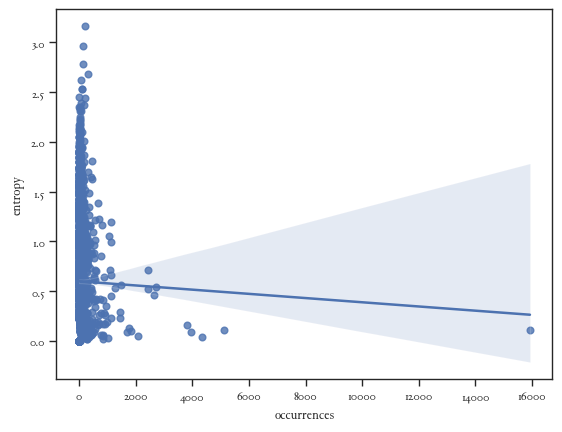

In [644]:
frequency_df = pd.DataFrame({"occurrences": df_simple["greek_lemma"].value_counts(), "deviations": df_diff["greek_lemma"].value_counts(), "entropy": df_simple.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))
}).dropna()
frequency_df = frequency_df#[frequency_df.occurrences < 1000]
#scipy.stats.spearmanr()

sns.regplot(y=frequency_df["entropy"], x=frequency_df["occurrences"])


## Have diphthongs stayed?

Spellings with diaeresis indicate spelling pronunciation

In [260]:
df_simple[df_simple["orthography"].str.contains("ⲟⲓ̈") & ~df_simple["greek_lemma"].str.endswith("ⲉⲱ")]#.join(per_lemma.set_index("greek_lemma")["earliest_attestation"], on="greek_lemma")["earliest_attestation"].plot.hist()

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters
id,,,,,,,,,,,
28514,ⲛ̣ϭⲟⲓ̈,ⲟⲩⲅⲕⲓⲁ,S,659.5,1119.0,200.0,"(200.0, 1119.0)",Luxor - SCA - Carter magazine O. 292063 (+ O. ...,7.0,ⲛϭⲟⲓ,{}
92768,ⲭⲟⲓ̈ⲕⲏ,ⲭⲟⲓⲕⲟⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Oxford - Bodleian Library MS Bruce 96 - Book o...,NaN,ⲭⲟⲓⲕⲏ,{}
92870,ϫⲟⲓ̈ⲕⲟⲥ,ⲭⲟⲓⲕⲟⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Oxford - Bodleian Library MS Bruce 96 - Book o...,NaN,ϫⲟⲓⲕⲟⲥ,{}
93018,ⲭⲟⲓ̈ⲕⲏ,ⲭⲟⲓⲕⲟⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Oxford - Bodleian Library MS Bruce 96 - Book o...,NaN,ⲭⲟⲓⲕⲏ,{}
126264,ⲙⲉⲧⲁⲛⲟⲓ̈ⲁ,ⲙⲉⲧⲁⲛⲟⲓⲁ,S,424.5,499.0,350.0,"(350.0, 499.0)",London - British Library Add MS 5114 - Pistis ...,5.0,ⲙⲉⲧⲁⲛⲟⲓⲁ,{}
...,...,...,...,...,...,...,...,...,...,...,...
144609,ⲕⲟⲓ̈ⲛⲱⲛⲓⲁ,ⲕⲟⲓⲛⲱⲛⲓⲁ,S,NaN,NaN,NaN,"(200.0, 1299.0)",New York - The Morgan Library and Museum M.579...,NaN,ⲕⲟⲓⲛⲱⲛⲓⲁ,{}
183300,ⲕⲟⲓ̈ⲧⲱⲛ,ⲕⲟⲓⲧⲱⲛ,S,NaN,NaN,NaN,"(200.0, 1299.0)","London - British Library Or. 3581B.51, (95-96)...",NaN,ⲕⲟⲓⲧⲱⲛ,{}
183348,ⲟⲓ̈ⲕⲟⲛⲟⲙⲟⲥ,ⲟⲓⲕⲟⲛⲟⲙⲟⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Paris - Bibliothèque Nationale Copte 129.19.30...,NaN,ⲟⲓⲕⲟⲛⲟⲙⲟⲥ,{}


In [261]:
len(df_diff[df_diff["norm"] == "ⲟⲓ"])

527

In [262]:
df_diff[df_diff["norm"] == "ⲟⲓ"].deviation.value_counts()

deviation
ⲟⲓ→ⲉ       193
ⲟⲓ→ⲏ        80
ⲟⲓ→ⲓ        77
ⲟⲓ→ⲁⲓ       36
ⲟⲓ→∅        22
ⲟⲓ→ⲩ        21
ⲟⲓ→ⲉⲓ       18
ⲟⲓ→ⲟⲥ       16
ⲟⲓ→ⲟϩⲓ      15
ⲟⲓ→ⲟ        12
ⲟⲓ→ϯ         8
ⲟⲓ→ⲱⲓ        6
ⲟⲓ→ϩⲩ        4
ⲟⲓ→ⲟⲉⲓ       3
ⲟⲓ→ⲓⲟⲛ       3
ⲟⲓ→ⲱⲥ        2
ⲟⲓ→ⲱ         2
ⲟⲓ→ϩⲟ        1
ⲟⲓ→ⲟⲩⲕ       1
ⲟⲓ→ⲟⲩ        1
ⲟⲓ→ⲟⲛ        1
ⲟⲓ→ⲉⲟⲥ       1
ⲟⲓ→ⲁⲓⲟⲥ      1
ⲟⲓ→ϩⲏ        1
ⲟⲓ→ⲑⲏ        1
ⲟⲓ→ⲱϩⲓ       1
Name: count, dtype: int64

In [263]:
df_simple[df_simple["orthography"].str.contains("ⲁⲓ̈")]#.join(per_lemma.set_index("greek_lemma")["earliest_attestation"], on="greek_lemma")["earliest_attestation"].plot.hist()

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,century,orthography_clean,strange_characters
id,,,,,,,,,,,
28145,ⲕⲁⲓ̈ⲅⲁⲣ,ⲕⲁⲓⲅⲁⲣ,S,659.5,1119.0,200.0,"(200.0, 1119.0)",Luxor - SCA - Carter magazine O. 291823 - O.Fr...,7.0,ⲕⲁⲓⲅⲁⲣ,{}
149028,ⲁⲓ̈ⲱⲛ,ⲁⲓⲱⲛ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Codex Tchacos - Book of Allogenes,NaN,ⲁⲓⲱⲛ,{}
79465,ⲕⲁⲓ̈ⲧⲟⲓ,ⲕⲁⲓⲧⲟⲓ,S,349.5,399.0,300.0,"(300.0, 399.0)",Berlin - Ägyptisches Museum P. 20915 - Berline...,4.0,ⲕⲁⲓⲧⲟⲓ,{}
80412,ⲁⲓ̣̈ⲱ̣[ⲛ],ⲁⲓⲱⲛ,S,349.5,399.0,300.0,"(300.0, 399.0)",Berlin - Ägyptisches Museum P. 20915 - Berline...,4.0,ⲁⲓⲱⲛ,{}
81575,ⲡ̣ⲣ̣ⲟ̣[ϩ]ⲁⲓ̈ⲣⲉⲥⲓⲥ,ⲡⲣⲟⲁⲓⲣⲉⲥⲓⲥ,S,349.5,399.0,300.0,"(300.0, 399.0)",Berlin - Ägyptisches Museum P. 20915 - Berline...,4.0,ⲡⲣⲟϩⲁⲓⲣⲉⲥⲓⲥ,{}
...,...,...,...,...,...,...,...,...,...,...,...
196844,ⲥⲩⲛⲁⲓ̈ⲛⲉⲥⲓⲥ,ⲥⲩⲛⲁⲓⲛⲉⲥⲓⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",Berlin - Ägyptisches Museum P. 22141 Ro - BKU ...,NaN,ⲥⲩⲛⲁⲓⲛⲉⲥⲓⲥ,{}
200842,ⲕⲁⲗⲩⲗⲁⲓ̈ⲟⲛ,ⲕⲁⲣⲉⲗⲁⲓⲟⲛ,S,NaN,NaN,NaN,"(200.0, 1299.0)","Abydos, Osirieion, in situ - SB Kopt. III 1536...",NaN,ⲕⲁⲗⲩⲗⲁⲓⲟⲛ,{}
188191,ⲇⲓⲕⲁⲓ̈ⲟⲥ,ⲇⲓⲕⲁⲓⲟⲥ,S,NaN,NaN,NaN,"(200.0, 1299.0)",TEST Pierpont Morgan M.578 -,NaN,ⲇⲓⲕⲁⲓⲟⲥ,{}


In [264]:
len(df_diff[df_diff["norm"] == "ⲁⲓ"])

2149

In [265]:
df_diff[df_diff["norm"] == "ⲁⲓ"].deviation.value_counts()

deviation
ⲁⲓ→ⲉ       1448
ⲁⲓ→ⲁ        341
ⲁⲓ→ⲏ         87
ⲁⲓ→ⲉⲛⲟⲥ      47
ⲁⲓ→ⲩ         40
ⲁⲓ→ⲉⲓ        37
ⲁⲓ→ⲓ         29
ⲁⲓ→ϩⲉ        27
ⲁⲓ→∅         19
ⲁⲓ→ⲉⲛⲟⲛ      15
ⲁⲓ→ⲟⲓ        14
ⲁⲓ→ⲁⲉⲓ       10
ⲁⲓ→ϩⲩ         5
ⲁⲓ→ⲟ          5
ⲁⲓ→ⲱ          3
ⲁⲓ→ⲏ          2
ⲁⲓ→ⲁⲉ         2
ⲁⲓ→ⲉⲛⲏ        2
ⲁⲓ→ϩⲁⲉ        1
ⲁⲓ→ⲁⲉⲓⲕ       1
ⲁⲓ→ϩⲁ         1
ⲁⲓ→ⲩⲓ         1
ⲁⲓ→ⲉⲛⲱⲛ       1
ⲁⲓ→ⲏⲛ         1
ⲁⲓ→ⲁⲣⲓ        1
ⲁⲓ→ⲉ          1
ⲁⲓ→ⲉⲏ         1
ⲁⲓ→ⲉⲛ         1
ⲁⲓ→ⲏⲏ         1
ⲁⲓ→ⲁⲩ         1
ⲁⲓ→ⲉⲣⲉ        1
ⲁⲓ→ϩⲏ         1
ⲁⲓ→ⲉⲕ         1
ⲁⲓ→ⲁⲛⲓ        1
Name: count, dtype: int64

<Axes: xlabel='date_approximate', ylabel='Count'>

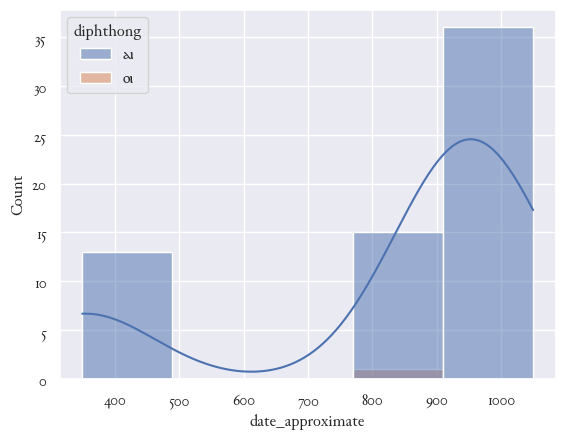

In [266]:
spelling_pronunciation = df_diff_well_dated[
    (df_diff_well_dated["greek_lemma"].str.contains("ⲟⲓ") & df_diff_well_dated["orthography"].str.contains("ⲟⲓ̈"))
    | (df_diff_well_dated["greek_lemma"].str.contains("ⲁⲓ") & df_diff_well_dated["orthography"].str.contains("ⲁⲓ̈"))
].copy()
spelling_pronunciation["diphthong"] = spelling_pronunciation["orthography"].apply(lambda x: "ⲟⲓ" if "ⲟⲓ̈" in x else "ⲁⲓ" if "ⲁⲓ̈" in x else "?")
sns.histplot(data=spelling_pronunciation, x='date_approximate', hue='diphthong', bins=5, kde=True)

In [267]:
spelling_pronunciation

,norm,var,context_left,context_right,greek_lemma,orthography,orthography_clean,dialect_group,manuscript_text,date_approximate,earliest,latest,century,type,deviation,shift_class,shift_origin,diphthong
id,,,,,,,,,,,,,,,,,,
81575,∅,ϩ,ⲡⲣⲟ,ⲁⲓⲣⲉⲥⲓⲥ,ⲡⲣⲟⲁⲓⲣⲉⲥⲓⲥ,ⲡ̣ⲣ̣ⲟ̣[ϩ]ⲁⲓ̈ⲣⲉⲥⲓⲥ,ⲡⲣⲟϩⲁⲓⲣⲉⲥⲓⲥ,S,Berlin - Ägyptisches Museum P. 20915 - Berline...,349.5,300.0,399.0,4.0,consonants,∅→ϩ,aspiration,nongreek,ⲁⲓ
4159,ⲓⲟⲩ,ⲟⲩⲓ,#,ⲇⲁⲓⲟⲥ,ⲓⲟⲩⲇⲁⲓⲟⲥ,ⲟⲩⲓ|ⲇⲁⲓ̈,ⲟⲩⲓⲇⲁⲓ,B,Geneva - Fondation Bodmer 3 - Gospel of John,349.5,300.0,399.0,4.0,vowels,ⲓⲟⲩ→ⲟⲩⲓ,None,None,ⲁⲓ
4177,ⲓⲟⲩ,ⲟⲩⲓ,#,ⲇⲁⲓⲟⲥ,ⲓⲟⲩⲇⲁⲓⲟⲥ,ⲟⲩⲓ̈ⲇⲁⲓ̈,ⲟⲩⲓⲇⲁⲓ,B,Geneva - Fondation Bodmer 3 - Gospel of John,349.5,300.0,399.0,4.0,vowels,ⲓⲟⲩ→ⲟⲩⲓ,None,None,ⲁⲓ
4514,ⲓⲟⲩ,ⲟⲩⲓ,#,ⲇⲁⲓⲟⲥ,ⲓⲟⲩⲇⲁⲓⲟⲥ,ⲟⲩⲓⲇⲁⲓ̈,ⲟⲩⲓⲇⲁⲓ,B,Geneva - Fondation Bodmer 3 - Gospel of John,349.5,300.0,399.0,4.0,vowels,ⲓⲟⲩ→ⲟⲩⲓ,None,None,ⲁⲓ
4627,ⲓ,∅,#,ⲟⲩⲇⲁⲓⲟⲥ,ⲓⲟⲩⲇⲁⲓⲟⲥ,ⲟⲩⲇⲁⲓ̈,ⲟⲩⲇⲁⲓ,B,Geneva - Fondation Bodmer 3 - Gospel of John,349.5,300.0,399.0,4.0,vowels,ⲓ→∅,epenthesis,nongreek,ⲁⲓ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187468,ⲏ,ⲩ,ⲥⲡ,ⲗⲁⲓⲟⲛ,ⲥⲡⲏⲗⲁⲓⲟⲛ,ⲥⲡⲩⲗⲁⲓ̈ⲟⲛ,ⲥⲡⲩⲗⲁⲓⲟⲛ,S,New York - The Morgan Library and Museum M.633...,987.0,975.0,999.0,10.0,vowels,ⲏ→ⲩ,front_vowel,nongreek,ⲁⲓ
187500,ⲏ,ⲩ,ⲥⲡ,ⲗⲁⲓⲟⲛ,ⲥⲡⲏⲗⲁⲓⲟⲛ,ⲥⲡⲩⲗⲁⲓ̈ⲟⲛ,ⲥⲡⲩⲗⲁⲓⲟⲛ,S,New York - The Morgan Library and Museum M.633...,987.0,975.0,999.0,10.0,vowels,ⲏ→ⲩ,front_vowel,nongreek,ⲁⲓ
187502,ⲏ,ⲩ,ⲥⲡ,ⲗⲁⲓⲟⲛ,ⲥⲡⲏⲗⲁⲓⲟⲛ,ⲥⲡⲩⲗⲁⲓ̈ⲟⲛ,ⲥⲡⲩⲗⲁⲓⲟⲛ,S,New York - The Morgan Library and Museum M.633...,987.0,975.0,999.0,10.0,vowels,ⲏ→ⲩ,front_vowel,nongreek,ⲁⲓ


<Axes: xlabel='date_approximate', ylabel='Count'>

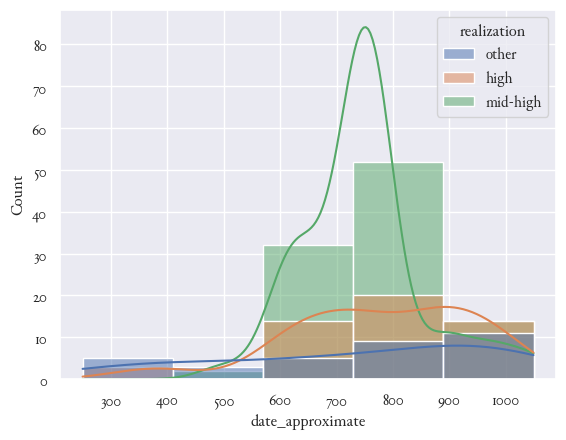

In [268]:
oi = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲟⲓ")].copy()
oi["realization"] = oi["var"].apply(lambda x: "high" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "other")
sns.histplot(data=oi, x='date_approximate', hue='realization', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

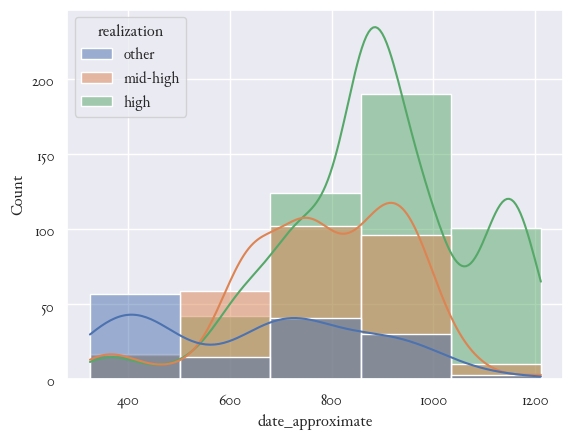

In [269]:
eta = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲏ")].copy()
eta["realization"] = eta["var"].apply(lambda x: "high" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ", "ⲟⲓ"} else "other")
sns.histplot(data=eta, x='date_approximate', hue='realization', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

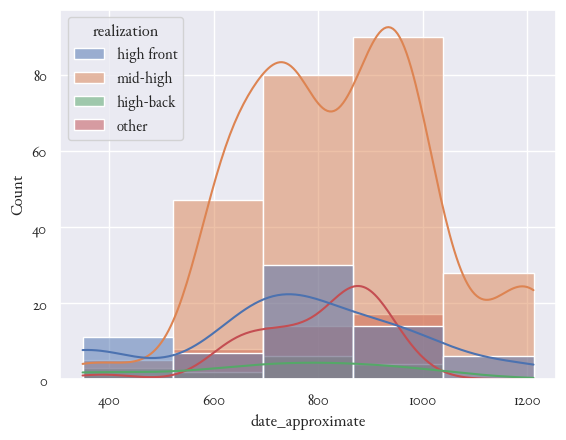

In [270]:
upsilon = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲩ")].copy()
upsilon["realization"] = upsilon["var"].apply(lambda x: "high front" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ", "ⲟⲓ"} else "high-back" if x in {"ⲟⲩ", "ⲟ", "ⲱ"} else "other")
sns.histplot(data=upsilon, x='date_approximate', hue='realization', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

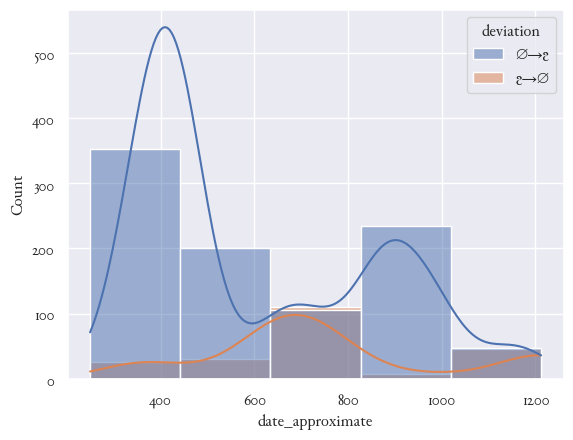

In [271]:
un_aspiration = df_diff_well_dated[((df_diff_well_dated["norm"] == "ϩ") & (df_diff_well_dated["var"] == "∅")) | ((df_diff_well_dated["norm"] == "∅") & (df_diff_well_dated["var"] == "ϩ"))].copy()
sns.histplot(data=un_aspiration, x='date_approximate', hue='deviation', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

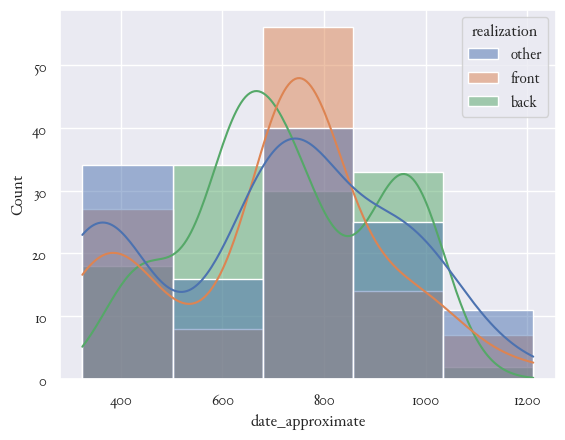

In [272]:
alpha = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲁ")].copy()
alpha["realization"] = alpha["var"].apply(lambda x: "front" if x in {"ⲩ", "ⲓ", "ⲉⲓ", "ⲉ", "ⲏ", "ⲁⲓ", "ⲟⲓ"} else "back" if x in {"ⲟⲩ", "ⲟ", "ⲱ"} else "other")
sns.histplot(data=alpha, x='date_approximate', hue='realization', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

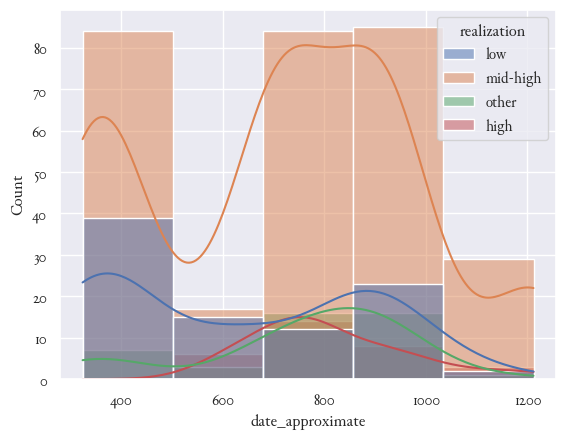

In [273]:
ai = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲁⲓ")].copy()
ai["realization"] = ai["var"].apply(lambda x: "high" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "low" if x in {"ⲁ"} else "other")
sns.histplot(data=ai, x='date_approximate', hue='realization', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

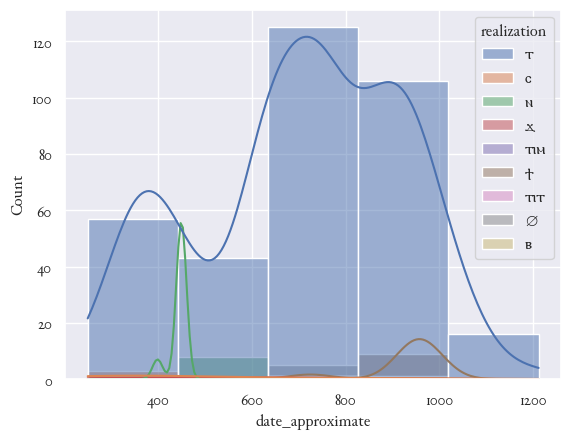

In [274]:
delta = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲇ")].copy()
delta["realization"] = delta["var"]#.apply(lambda x: "high" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "low" if x in {"ⲁ"} else "other")
sns.histplot(data=delta, x='date_approximate', hue='realization', bins=5, kde=True)

In [275]:
df_diff[(df_diff["norm"] == "ⲇ") & (df_diff["var"] == "ⲥ")]

,norm,var,context_left,context_right,greek_lemma,orthography,orthography_clean,dialect_group,manuscript_text,date_approximate,earliest,latest,century,type,deviation,shift_class,shift_origin
id,,,,,,,,,,,,,,,,,
3472,ⲇ,ⲥ,ⲥⲧⲁ,ⲓⲟⲛ,ⲥⲧⲁⲇⲓⲟⲛ,ⲥⲧⲁⲥⲓⲟⲛ,ⲥⲧⲁⲥⲓⲟⲛ,B,Geneva - Fondation Bodmer 3 - Gospel of John,349.5,300.0,399.0,4.0,consonants,ⲇ→ⲥ,None,None
4512,ⲇ,ⲥ,ⲥⲧⲁ,ⲓⲟⲛ,ⲥⲧⲁⲇⲓⲟⲛ,ⲥⲧⲁⲥⲓⲟⲛ,ⲥⲧⲁⲥⲓⲟⲛ,B,Geneva - Fondation Bodmer 3 - Gospel of John,349.5,300.0,399.0,4.0,consonants,ⲇ→ⲥ,None,None
106159,ⲇ,ⲥ,ⲉⲓ,ⲟⲥ,ⲉⲓⲇⲟⲥ,ⲉⲓⲥⲟⲥ,ⲉⲓⲥⲟⲥ,L,Excavation Inv. No. A/5/109 - P.KellisCopt. 45...,349.5,300.0,399.0,4.0,consonants,ⲇ→ⲥ,None,None
59468,ⲇ,ⲥ,ⲁⲉⲣⲟ,ⲓⲟⲥ,ⲁⲉⲣⲟⲇⲓⲟⲥ,ⲁⲉⲣⲟⲥⲓⲟⲥ,ⲁⲉⲣⲟⲥⲓⲟⲥ,S,"Nag Hammadi Codex III - Egyptian Gospel, The",NaN,350.0,NaN,NaN,consonants,ⲇ→ⲥ,None,None
102340,ⲇ,ⲥ,#,ⲓⲁⲑⲏⲕⲏ,ⲇⲓⲁⲑⲏⲕⲏ,ⲥ̣ⲓⲁⲑⲏⲕⲓ,ⲥⲓⲁⲑⲏⲕⲓ,S,New Haven - Yale University - Beinecke Library...,699.5,600.0,799.0,7.0,consonants,ⲇ→ⲥ,None,None
85384,ⲇ,ⲥ,ⲡⲁⲣⲁ,ⲉⲓⲥⲟⲥ,ⲡⲁⲣⲁⲇⲉⲓⲥⲟⲥ,ⲡⲁⲣⲁⲥⲓⲥⲟⲥ,ⲡⲁⲣⲁⲥⲓⲥⲟⲥ,S,Pierpont Morgan M.595 - Homily on the Passion ...,849.5,825.0,874.0,9.0,consonants,ⲇ→ⲥ,None,None


<Axes: xlabel='date_approximate', ylabel='Count'>

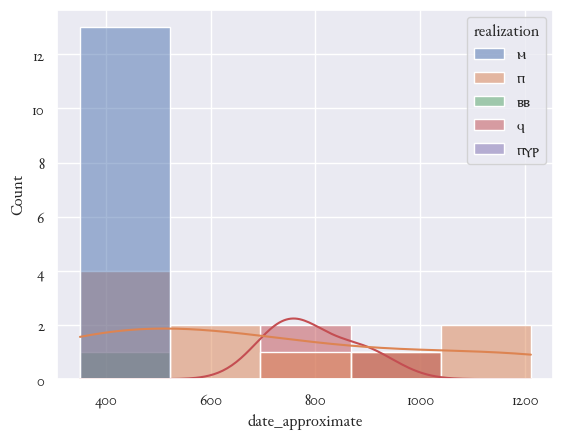

In [276]:
beta = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲃ")].copy()
beta["realization"] = beta["var"]#.apply(lambda x: "high" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "low" if x in {"ⲁ"} else "other")
sns.histplot(data=beta, x='date_approximate', hue='realization', bins=5, kde=True)

<Axes: xlabel='date_approximate', ylabel='Count'>

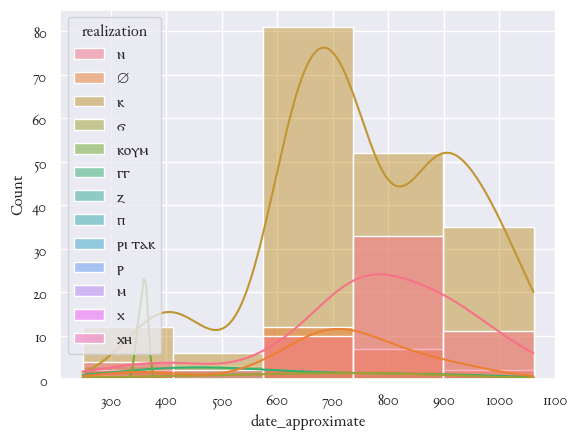

In [277]:
gamma = df_diff_well_dated[(df_diff_well_dated["norm"] == "ⲅ")].copy()
gamma["realization"] = gamma["var"]#.apply(lambda x: "high" if x in {"ⲩ", "ⲓ", "ⲉⲓ"} else "mid-high" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "low" if x in {"ⲁ"} else "other")
sns.histplot(data=gamma, x='date_approximate', hue='realization', bins=5, kde=True)

In [929]:
xtab_greek_shifts = pd.crosstab(df_diff_well_dated.earliest < 705, df_diff_well_dated.type).rename(index={True: "before Arabic", False: "after Arabic"})
print(contingency_statistics(xtab_greek_shifts))
xtab_greek_shifts

{'χ²': 254.86146593276672, 'p-value': 5.837203160376663e-54, 'DOF': 4, 'V': 0.1361793682611675}


type,consonants,mixed,mixed (delete),mixed (insert),vowels
earliest,,,,,
after Arabic,1713,496,347,218,3479
before Arabic,2840,554,436,419,3241


In [931]:
chi2_deluxe(xtab_greek_shifts)

type,consonants,mixed,mixed (delete),mixed (insert),vowels
earliest,,,,,
after Arabic,"–, χ² = 62.07 ***","+, χ² = 0.70 n. s.","–, χ² = 0.24 n. s.","–, χ² = 17.80 ***","+, χ² = 58.09 ***"
before Arabic,"+, χ² = 51.82 ***","–, χ² = 0.58 n. s.","+, χ² = 0.20 n. s.","+, χ² = 14.86 **","–, χ² = 48.49 ***"


## Coarticulation

In [924]:
def place_of_articulation(x):
    if x in {"ⲃ", "ⲡ", "ⲫ", "ⲙ", "ⲯ"}:
        return "labial"
    elif x in {"ⲅ", "ⲕ", "ⲭ", "ⲝ"}:
        return "velar"
    elif x in {"ⲇ", "ⲧ", "ⲑ", "ⲗ", "ⲛ", "ⲣ", "ⲥ", "ⲍ"}:
        return "alveolar"
    else:
        return None


def compare_vowels(vowel1, vowel2, strata):
    # Create a mapping of vowels to their stratum index
    stratum_index = {vowel: index for index, stratum in enumerate(strata) for vowel in stratum}
    
    # Get the indices of the vowels
    index1 = stratum_index.get(vowel1)
    index2 = stratum_index.get(vowel2)
    
    # Compare the indices
    if index1 is None or index2 is None:
        return None  # Return None if one or both vowels are not found
    elif index1 < index2:
        return -1  # vowel1 is in an earlier stratum
    elif index1 > index2:
        return +1  # vowel1 is in a later stratum
    else:
        return 0  # Both vowels are in the same stratum

# assuming early koine inventory
vowel_height = [["ⲓ", "ⲉⲓ", "ⲟⲩ", "ⲏ", "ⲟⲓ", "ⲩ"], ["ⲁⲓ", "ⲉ", "ⲟ", "ⲱ"], ["ⲁ"]]
vowel_frontness = [["ⲓ", "ⲉⲓ", "ⲩ", "ⲟⲓ", "ⲏ"], ["ⲁⲓ", "ⲉ"], ["ⲁ"], ["ⲟ", "ⲱ"], ["ⲟⲩ"]]
vowel_roundness = [["ⲓ", "ⲉⲓ", "ⲏ", "ⲁⲓ", "ⲉ", "ⲁ"], ["ⲩ", "ⲟⲓ", "ⲟ", "ⲟⲩ", "ⲱ"]]

def process_height(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_height)
    if comparison is not None:
        if comparison < 0:
            return "lowering"
        elif comparison > 0:
            return "raising"
        else:
            #print(comparison, row["norm"], row["var"])
            return "none"

def process_frontness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_frontness)
    if comparison is not None:
        if comparison < 0:
            return "backing"
        elif comparison > 0:
            return "fronting"
        else:
            return "none"

def process_roundness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_roundness)
    if comparison is not None:
        if comparison < 0:
            return "unrounding"
        elif comparison > 0:
            return "rounding"
        else:
            return "none"

x = df_diff[(df_diff["norm"].isin(vowels|diphthongs)) & df_diff["var"].isin(vowels | diphthongs) & (df_diff["context_right"] != "#")].copy()
x["environment_left"] = x.apply(lambda row: place_of_articulation(row.context_left[-1]), axis=1)
x["environment_right"] = x.apply(lambda row: place_of_articulation(row.context_right[0]), axis=1)
x["environment"] = x["environment_left"] + "…" + x["environment_right"]

### Raising / Lowering

In [906]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_height, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'χ²': 85.42974175220981, 'p-value': 2.8129841383091787e-19, 'DOF': 2, 'V': 0.06859153798516616}


col_0,lowering,none,raising
row_0,,,
non-rhotic environment,1857,10570,1538
rhotic environment,696,2877,620


In [907]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-rhotic environment,"–, χ² = 5.77 n. s.","+, χ² = 5.03 n. s.","–, χ² = 8.92 *"
rhotic environment,"+, χ² = 19.23 ***","–, χ² = 16.76 ***","+, χ² = 29.71 ***"


In [908]:
xtab_nasal_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲙ", "ⲛ"})), x.apply(process_height, axis=1)).rename(
    index={True: "after nasal", False: "after non-nasal"}
)
print(contingency_statistics(xtab_nasal_coarticulation))
xtab_nasal_coarticulation

{'χ²': 243.55343231279045, 'p-value': 1.2973111447556762e-53, 'DOF': 2, 'V': 0.11581454925901047}


col_0,lowering,none,raising
context_left,,,
after non-nasal,2040,11933,1714
after nasal,513,1514,444


In [888]:
chi2_deluxe(xtab_nasal_coarticulation)

col_0,lowering,none,raising
context_left,,,
after non-nasal,"–, χ² = 12.43 **","+, χ² = 8.59 *","–, χ² = 12.12 **"
after nasal,"+, χ² = 78.91 ***","–, χ² = 54.54 ***","+, χ² = 76.96 ***"


In [864]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_height, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'χ²': 127.653775571301, 'p-value': 1.906930379684372e-28, 'DOF': 2, 'V': 0.0838460921893284}


col_0,lowering,none,raising
row_0,,,
non-velar environment,2062,10068,1434
velar environment,491,3379,724


In [865]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-velar environment,"+, χ² = 12.58 **","+, χ² = 0.05 n. s.","–, χ² = 19.66 ***"
velar environment,"–, χ² = 37.15 ***","–, χ² = 0.16 n. s.","+, χ² = 58.05 ***"


In [866]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_height, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'χ²': 95.12679550704132, 'p-value': 2.2053565562794494e-21, 'DOF': 2, 'V': 0.07237980815718631}


col_0,lowering,none,raising
row_0,,,
non-labial environment,1460,9032,1397
labial environment,1093,4415,761


In [867]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-labial environment,"–, χ² = 26.78 ***","+, χ² = 5.88 n. s.","–, χ² = 0.18 n. s."
labial environment,"+, χ² = 50.79 ***","–, χ² = 11.15 **","+, χ² = 0.34 n. s."


In [868]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_height, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'χ²': 217.350295788818, 'p-value': 6.353059890145435e-48, 'DOF': 2, 'V': 0.10940725249645221}


col_0,lowering,none,raising
row_0,,,
non-alveolar environment,327,2590,163
alveolar environment,2226,10857,1995


In [869]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-alveolar environment,"–, χ² = 25.97 ***","+, χ² = 41.89 ***","–, χ² = 112.63 ***"
alveolar environment,"+, χ² = 5.30 n. s.","–, χ² = 8.56 *","+, χ² = 23.01 ***"


### Fronting / Backing

In [870]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_frontness, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'χ²': 87.225793448066, 'p-value': 1.145934020446696e-19, 'DOF': 2, 'V': 0.0693088125833279}


col_0,backing,fronting,none
row_0,,,
non-rhotic environment,2077,1486,10402
rhotic environment,860,493,2840


In [871]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-rhotic environment,"–, χ² = 14.63 ***","–, χ² = 0.85 n. s.","+, χ² = 4.66 n. s."
rhotic environment,"+, χ² = 48.73 ***","+, χ² = 2.84 n. s.","–, χ² = 15.51 ***"


In [872]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'χ²': 29.891083396711117, 'p-value': 3.2302319719687496e-07, 'DOF': 2, 'V': 0.040572972091817816}


col_0,backing,fronting,none
row_0,,,
non-velar environment,2255,1386,9923
velar environment,682,593,3319


In [873]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-velar environment,"+, χ² = 1.70 n. s.","–, χ² = 5.76 n. s.","+, χ² = 0.10 n. s."
velar environment,"–, χ² = 5.02 n. s.","+, χ² = 17.02 ***","–, χ² = 0.29 n. s."


In [874]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_frontness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'χ²': 112.4547328308466, 'p-value': 3.808597112645329e-25, 'DOF': 2, 'V': 0.07869639951875763}


col_0,backing,fronting,none
row_0,,,
non-labial environment,1682,1271,8936
labial environment,1255,708,4306


In [875]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-labial environment,"–, χ² = 30.21 ***","–, χ² = 0.47 n. s.","+, χ² = 8.15 *"
labial environment,"+, χ² = 57.28 ***","+, χ² = 0.90 n. s.","–, χ² = 15.45 ***"


In [876]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'χ²': 168.41521593008784, 'p-value': 2.6859660965408302e-37, 'DOF': 2, 'V': 0.09630673449592178}


col_0,backing,fronting,none
row_0,,,
non-alveolar environment,353,193,2534
alveolar environment,2584,1786,10708


In [877]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-alveolar environment,"–, χ² = 42.31 ***","–, χ² = 60.65 ***","+, χ² = 36.89 ***"
alveolar environment,"+, χ² = 8.64 *","+, χ² = 12.39 **","–, χ² = 7.54 *"


### Rounding / unrounding

In [878]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'χ²': 257.4645936142004, 'p-value': 1.2367270330740168e-56, 'DOF': 2, 'V': 0.11907614079046773}


col_0,none,rounding,unrounding
row_0,,,
non-velar environment,10840,1420,1304
velar environment,3214,553,827


In [879]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-velar environment,"+, χ² = 11.12 **","–, χ² = 1.97 n. s.","–, χ² = 52.05 ***"
velar environment,"–, χ² = 32.83 ***","+, χ² = 5.80 n. s.","+, χ² = 153.69 ***"


In [880]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_roundness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'χ²': 165.83100917452012, 'p-value': 9.778086920579488e-37, 'DOF': 2, 'V': 0.09556500039964118}


col_0,none,rounding,unrounding
row_0,,,
non-labial environment,9545,1106,1238
labial environment,4509,867,893


In [881]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-labial environment,"+, χ² = 12.79 **","–, χ² = 26.73 ***","–, χ² = 17.73 ***"
labial environment,"–, χ² = 24.26 ***","+, χ² = 50.69 ***","+, χ² = 33.62 ***"


In [882]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'χ²': 37.28544864431695, 'p-value': 8.008804626403183e-09, 'DOF': 2, 'V': 0.045314342275202174}


col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,2430,381,269
alveolar environment,11624,1592,1862


In [883]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,"+, χ² = 0.89 n. s.","+, χ² = 6.42 n. s.","–, χ² = 23.65 ***"
alveolar environment,"–, χ² = 0.18 n. s.","–, χ² = 1.31 n. s.","+, χ² = 4.83 n. s."
